# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Author: Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm, colors
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

# Make sure user is in the right directory
assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
def config_plots():
    # Configure plot settings
    plt.rc('font', **{'family'     : 'sans-serif',
                      'sans-serif' : ['Arial'],
                      'size': 18
                      })
    plt.rc('figure', **{'autolayout' : True,
                        'figsize'    : (7, 5),
                        'facecolor'  : 'white',
                        'dpi'        : 150
                        })
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('axes',  labelsize='medium', grid=False)
    plt.rc('axes',  titlesize='medium')
    plt.rc('legend', fontsize='medium')

config_plots()
cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
DATA_INPUT_PATH = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Keep only high temperature data / ignore room temperature data
df = df[df['is_room_temp_aging'] == 0]

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

<ipython-input-6-c265eae0e8c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-6-c265eae0e8c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079858, -0.5742942233893628, -0.515878958670716)


0.7759259567826146

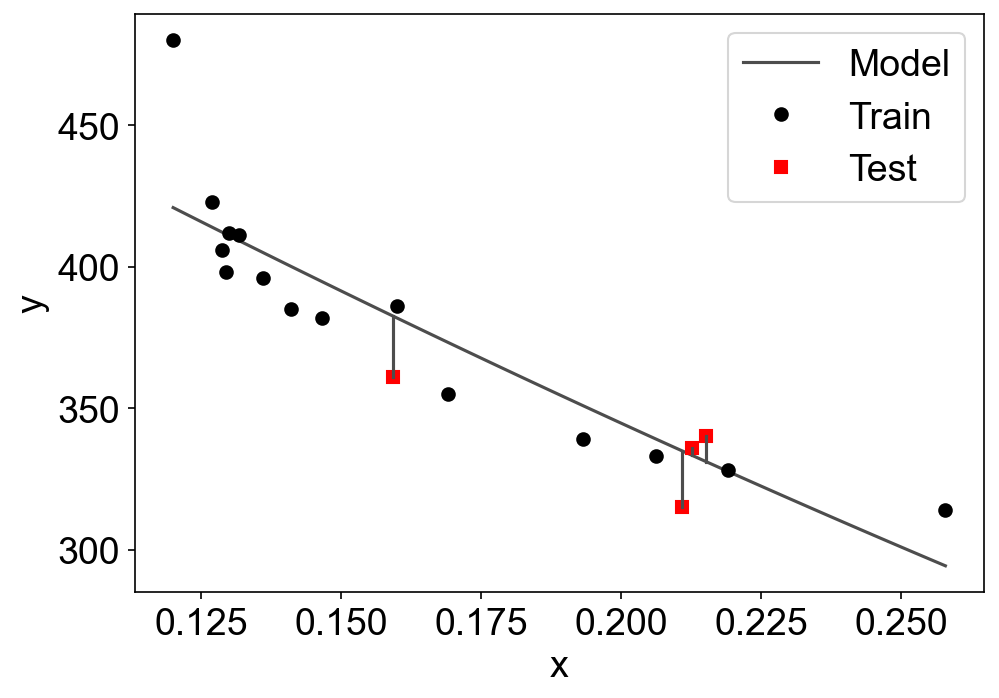

{'model': ElasticNet(),
 'rmse': 26.1747038931022,
 'rmse_std': 12.855823349899461,
 'baseline_rmse': 41.10741507537501,
 'baseline_rmse_std': 12.786893169646103,
 'corr': (-0.8743420294935467, -0.5817498333315735, -0.5275185883967966),
 'corr_std': (0.027977989226699605, 0.09105569538626525, 0.12848171789074142),
 'percent_error': 5.550017609143208,
 'percent_error_std': 2.226462080922798,
 'r2_score': -0.16990201981901903,
 'r2_score_std': 2.9855641081696223,
 'r2_score_manual': 0.5945631507882285,
 'features': ('var_q_c20_c365_c3_ah',
  'var_q_c20_c56_c3_ah',
  'var_q_c20_c159_c3_ah')}

In [8]:
def train_and_test_model(df, xvars, yvar, 
                         to_plot=1, model=None, num_experiments=None,
                         log=False, square=False, sqrt=False):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    num_experiments = num_experiments or 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))
    if square is True:
        df_nonans = df_nonans.apply(lambda x: x**2)
    if sqrt is True:
        df_nonans = df_nonans.apply(lambda x: np.sqrt(abs(x)))
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    r2_score_list = []
    rmse_list = []
    baseline_rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(num_experiments):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # apply standard scaler (fit only on train, transform both train and test)
        # keep originals for pltos
        X_train_original = X_train
        X_test_original = X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        (model, corr) = build_model(X_train, y_train, model)
        
        y_pred = model.predict(X_test)
        y_train_mean = np.mean(y_train)
        
        r2_score = model.score(X_test, y_test)
        
        if log is True:
            y_train = np.exp(y_train)
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            y_train_mean = np.exp(y_train_mean)
        if square is True:
            y_train = np.sqrt(y_train)
            y_pred = np.sqrt(y_pred)
            y_test = np.sqrt(y_test)
            y_train_mean = np.sqrt(y_train_mean)
        if sqrt is True:
            y_train = (y_train)**2
            y_pred = (y_pred)**2
            y_test = (y_test)**2
            y_train_mean = (y_train_mean)**2

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        r2_score_list.append(r2_score)
        baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            x_fit = np.linspace(np.min(X), np.max(X), 100)
            x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
            y_fit = model.predict(x_fit_trans)
            if log is True:
                y_fit = np.exp(y_fit)
            if square is True:
                y_fit = np.sqrt(y_fit)
            if sqrt is True:
                y_fit = y_fit ** 2
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train_original, y_train, 'o', color='k')
            plt.plot(X_test_original, y_test, 's', color='r')
            
            for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
                plt.plot([this_x, this_x], 
                         [this_y, this_ypred], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    # Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_baseline_rmse = np.mean(baseline_rmse_list)
    final_baseline_rmse_std = np.std(baseline_rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['baseline_rmse'] = final_baseline_rmse
    model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
    model_output_dict['features'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      log=True)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      square=True)

train_and_test_model(df, 
                     "var_q_c20_c365_c3_ah", 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     sqrt=True)

# multiple features
train_and_test_model(df, 
                     ["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"], 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     model=ElasticNet())

# Single feature

## Set up and fit/predict/score

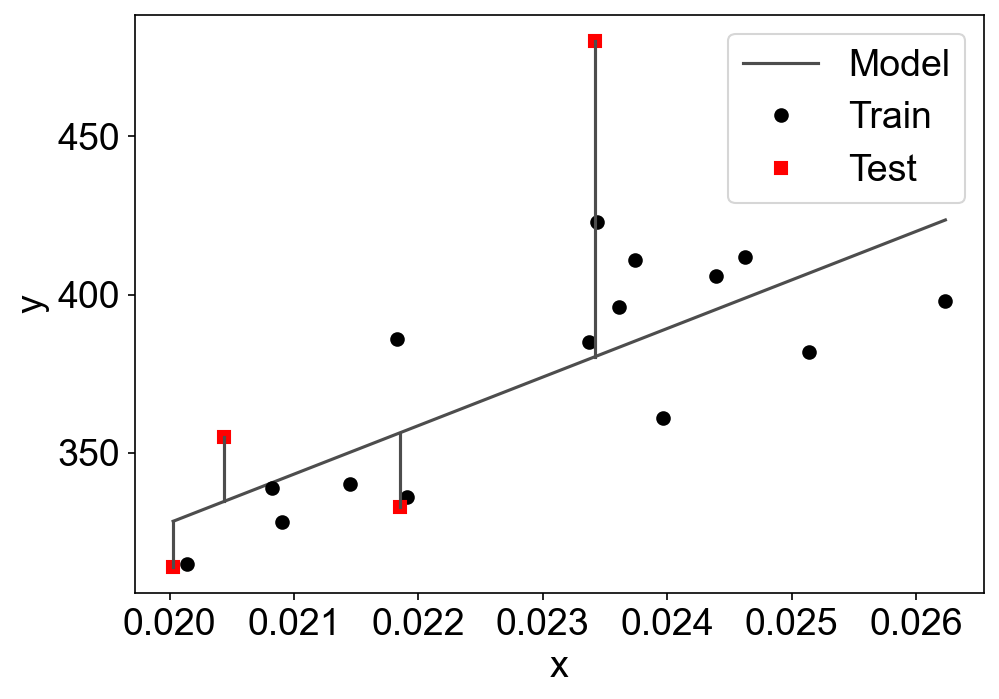

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar80 = 'cycles_to_80_pct'
yvar70 = 'cycles_to_70_pct'
yvar60 = 'cycles_to_60_pct'
yvar50 = 'cycles_to_50_pct'
yvar = yvar80

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


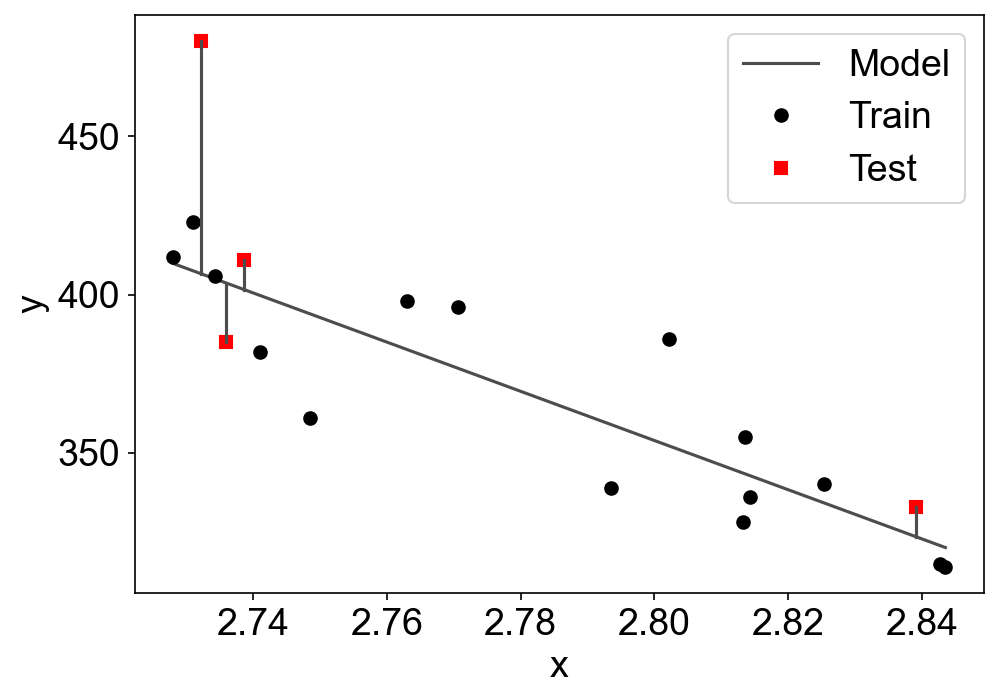

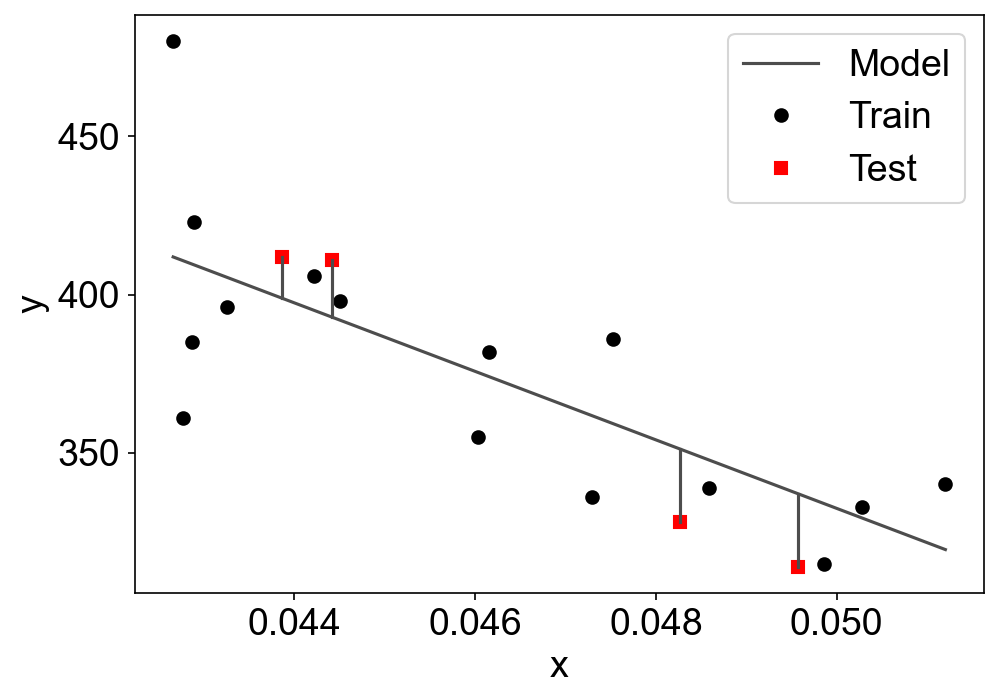

Working on cycle 56...


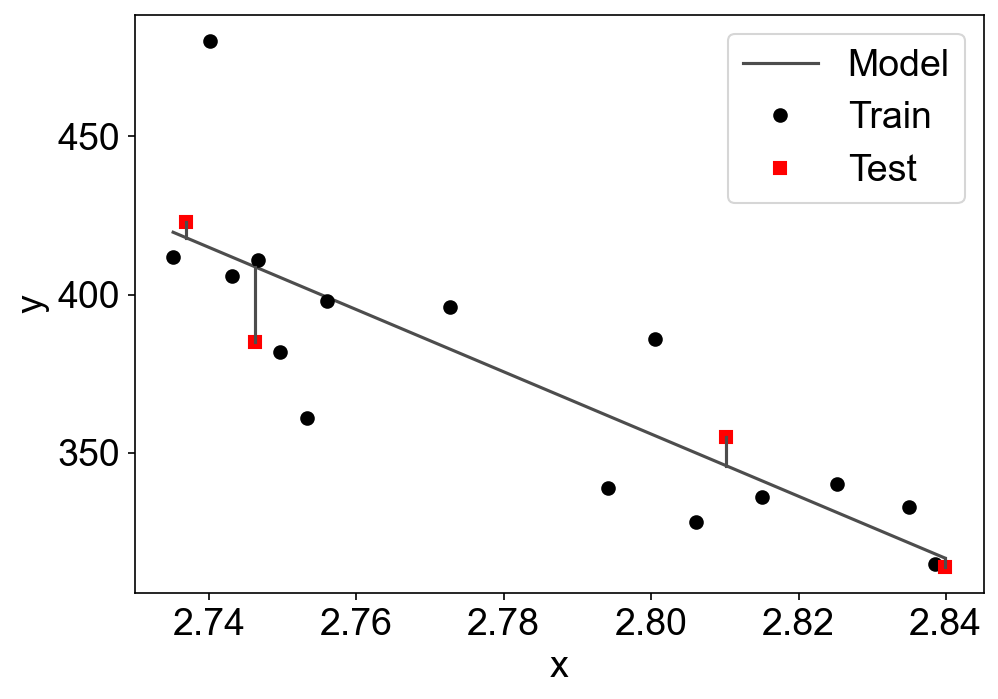

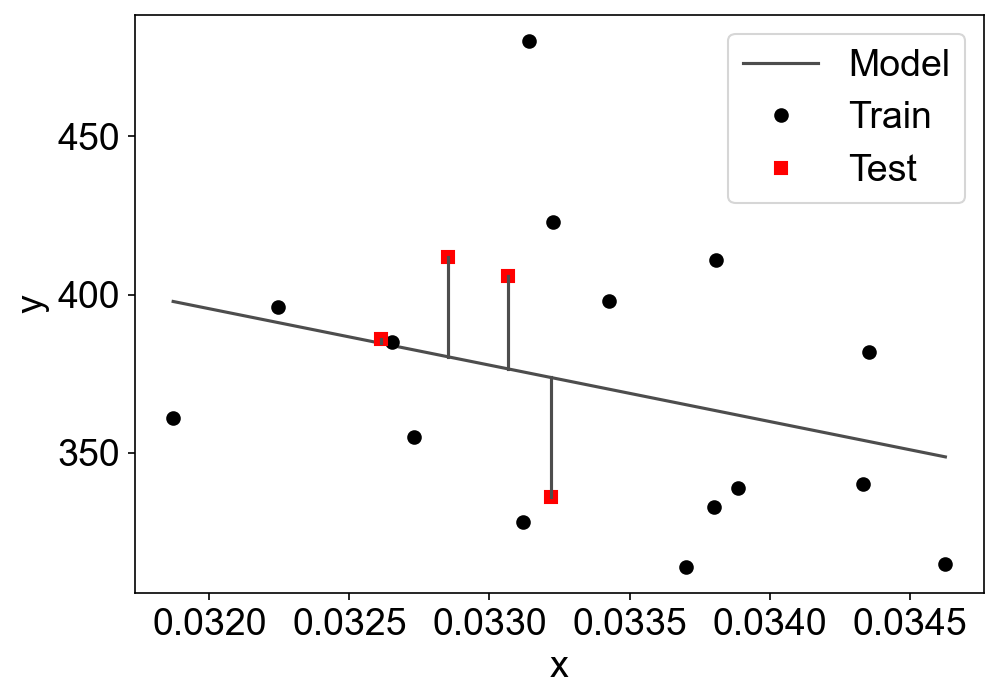

Working on cycle 159...


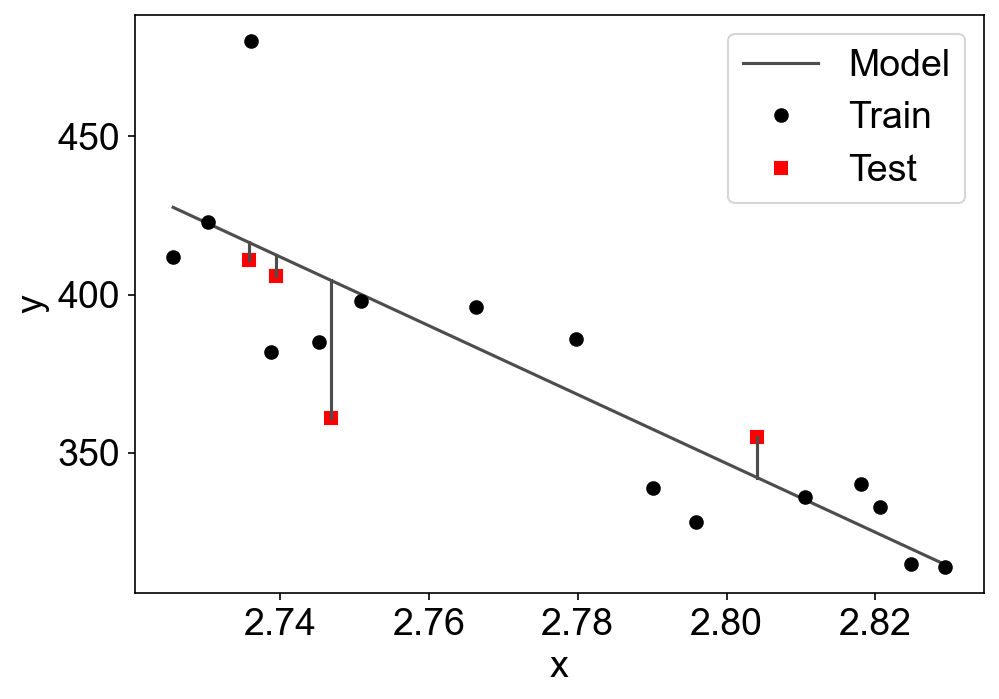

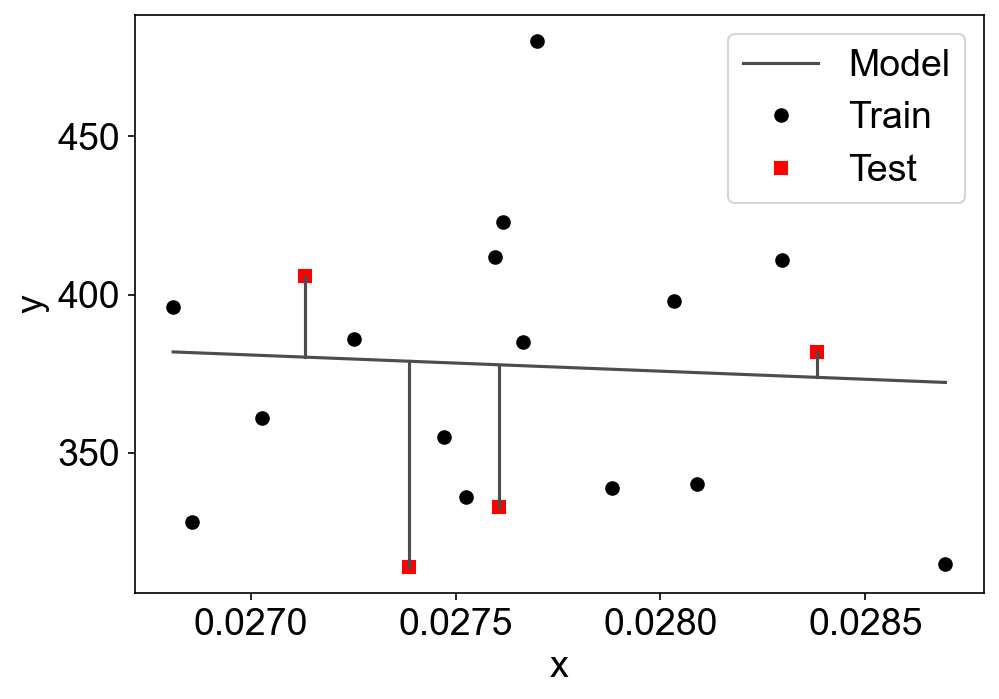

Working on cycle 262...


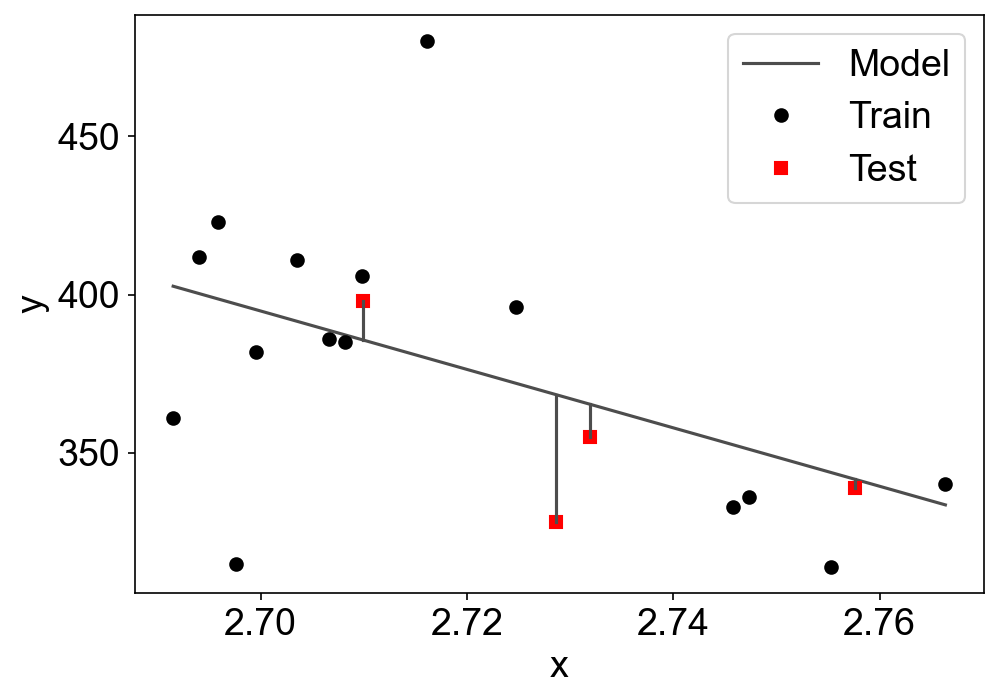

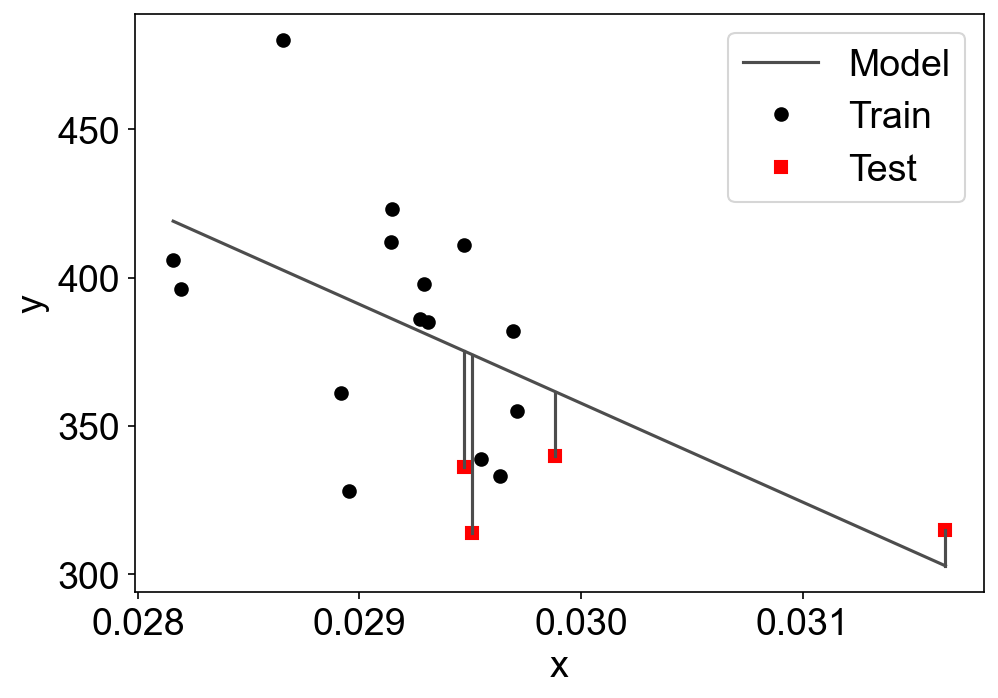

Working on cycle 365...


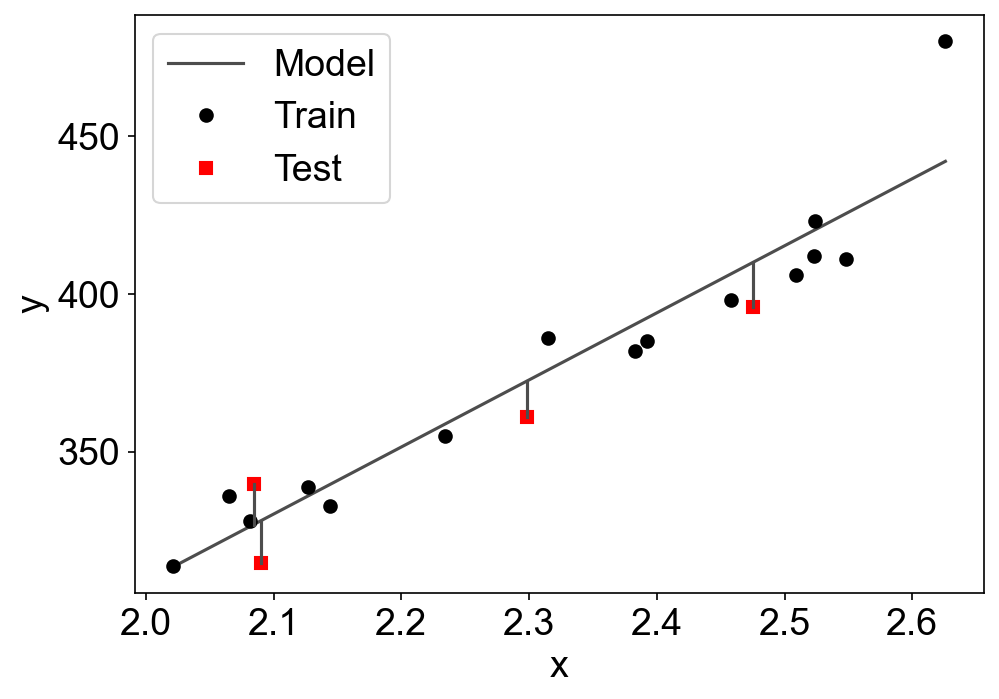

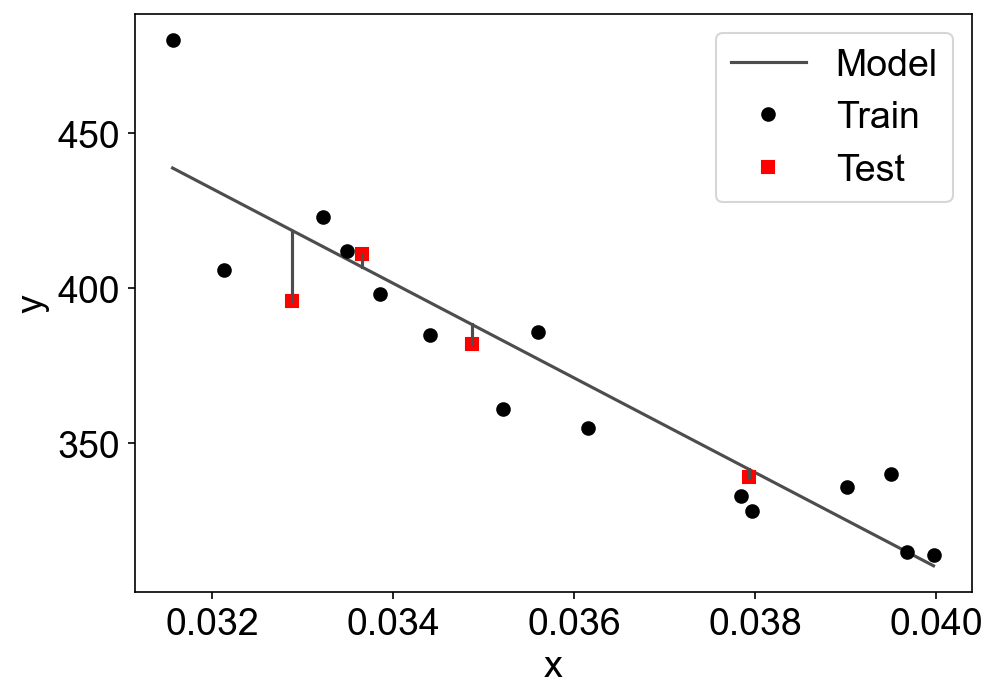

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 32.362438171946884,
   'rmse_std': 14.903088553096202,
   'baseline_rmse': 43.54542537442879,
   'baseline_rmse_std': 14.641727131882307,
   'corr': (0.7161295514279712,),
   'corr_std': (0.06423774136830607,),
   'percent_error': 6.657077333077296,
   'percent_error_std': 2.3389112957546203,
   'r2_score': -0.3577075022102044,
   'r2_score_std': 2.3222743061663014,
   'r2_score_manual': 0.4476715769001103,
   'features': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 23.83464472434318,
   'rmse_std': 10.645786590422162,
   'baseline_rmse': 41.944039567501875,
   'baseline_rmse_std': 13.530218454500421,
   'corr': (-0.852192508274776,),
   'corr_std': (0.030933984163473604,),
   'percent_error': 5.069405272294072,
   'percent_error_std': 1.9130907340589816,
   'r2_score': 0.10667231202031101,
   'r2_score_std': 1.6071515801890435,
 

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   27.09873666452019,
   41.713806786493194,
   45.659708976877155,
   39.97008474114485,
   16.17079201874418],
  'rmse_std': [nan,
   11.919151309368928,
   12.602257716661626,
   11.83257703898069,
   11.9382596330343,
   7.090630188318662],
  'corr': [nan,
   -0.8023017181489849,
   -0.33704810430861715,
   -0.030956587526132253,
   -0.5649515073487067,
   -0.9306190628968934],
  'corr_std': [nan,
   0.04281468293532959,
   0.08644956903570394,
   0.11859401426700354,
   0.047402964607047425,
   0.013111291697853031],
  'percent_error': [nan,
   6.132096579691183,
   9.786937557890898,
   11.21845562295001,
   9.489060537810714,
   3.502773333138175],
  'percent_error_std': [nan,
   2.310496467351273,
   2.7375928127002593,
   2.7405099909288233,
   2.890483249279829,
   1.333390811005462]},
 'Cn': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   23.83464472434318,
   20.08000325558342,
   22.

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

<Figure size 1050x750 with 0 Axes>

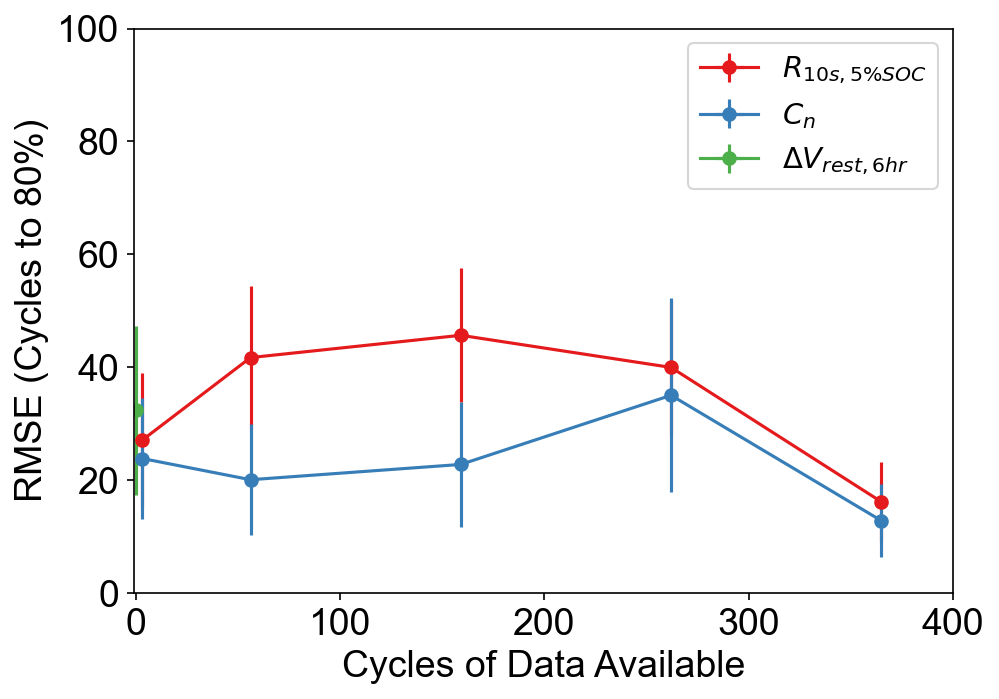

<Figure size 1050x750 with 0 Axes>

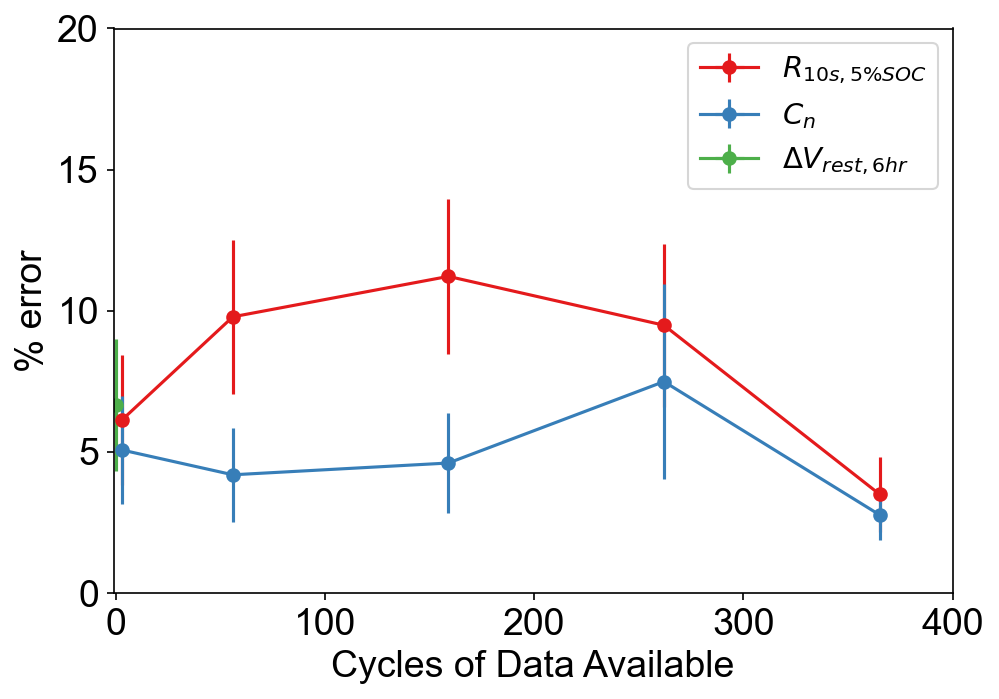

<Figure size 1050x750 with 0 Axes>

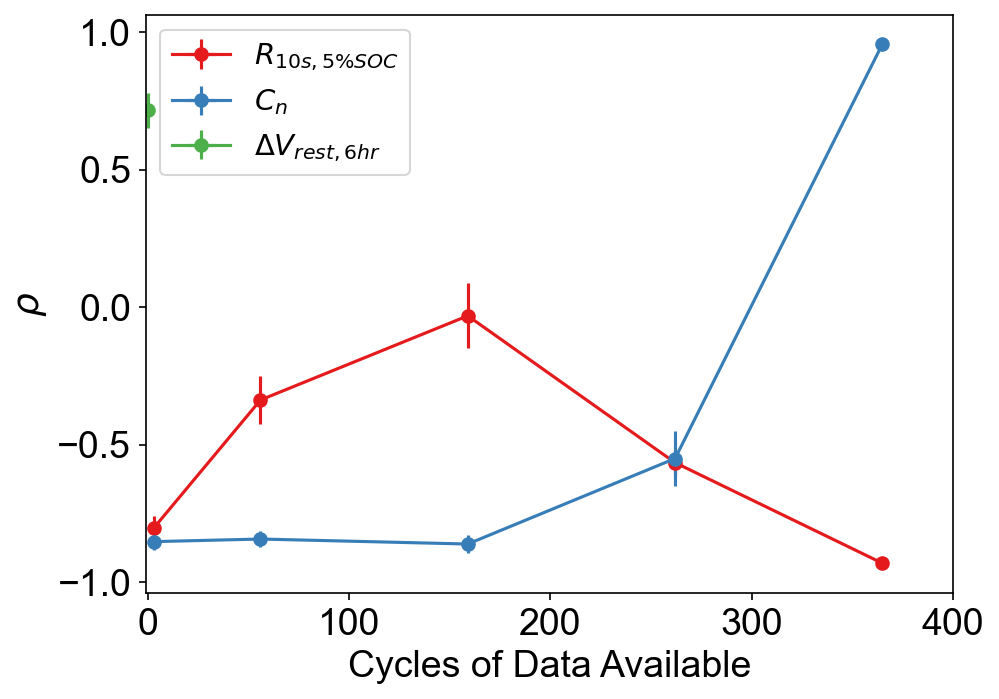

In [14]:
# Unpack and plot the dictionary of outputs
plt.figure()
fig, ax = plt.subplots()

labels = ["c%.0f" % number for number in output_dict[list(output_dict.keys())[0]]['cycle_index']]
labels[0] = "         Form."
    
# RMSE error (cycles to 70%)
for idx, key in enumerate(output_dict):

    x = output_dict[key]['cycle_index']
    y = output_dict[key]['rmse']
    error = output_dict[key]['rmse_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('RMSE (Cycles to 80%)')
plt.xlim((-1, 400))
plt.ylim((0, 100))
plt.legend(fontsize=14)

# Percent error
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['percent_error']
    error = output_dict[key]['percent_error_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('% error')
plt.ylim((0, 20))
plt.xlim((-1, 400))
plt.legend(fontsize=14)


# Correlation coefficient evolution
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['corr']
    error = output_dict[key]['corr_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel(r'$\rho$')
plt.xlim((-1, 400))
plt.legend(fontsize=14)

# Multiple features from formation

## Data analysis

In [15]:
yvar = yvar50

Select relevant formation features

In [16]:
form_select = lambda x: x.startswith("form_") and "trace" not in x and "rebound" not in x
form_features = list(filter(form_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_form = df[form_features + labels]
df_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah  19 non-null     float64
 1   form_last_charge_voltage_after_1s            19 non-null     float64
 2   form_last_charge_voltage_after_10s           19 non-null     float64
 3   form_last_charge_voltage_after_60s           19 non-null     float64
 4   form_first_charge_capacity_ah                19 non-null     float64
 5   form_first_discharge_capacity_ah             19 non-null     float64
 6   form_first_cycle_efficiency                  19 non-null     float64
 7   form_final_discharge_capacity_ah             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr      19 non-null     float64
 9   form_6hr_rest_delta_voltage_v_0_to_2_hr      19 non-null     float64
 10  form

In [17]:
df_form_sq = df_form.apply(lambda x: x**2).rename(lambda s: s + "_squared", axis="columns")
df_form_sq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 31 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah_squared  19 non-null     float64
 1   form_last_charge_voltage_after_1s_squared            19 non-null     float64
 2   form_last_charge_voltage_after_10s_squared           19 non-null     float64
 3   form_last_charge_voltage_after_60s_squared           19 non-null     float64
 4   form_first_charge_capacity_ah_squared                19 non-null     float64
 5   form_first_discharge_capacity_ah_squared             19 non-null     float64
 6   form_first_cycle_efficiency_squared                  19 non-null     float64
 7   form_final_discharge_capacity_ah_squared             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr_squared      19 non-null     flo

In [18]:
df_form_plus_sq = pd.concat([df_form, df_form_sq], axis=1)
df_form_plus_sq.head()

form_first_discharge_capacity_below_3p2v_ah  \
0                                     0.077820   
1                                     0.073791   
2                                     0.074725   
3                                     0.069433   
4                                     0.073127   

   form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                           3.393505                            3.403936   
1                           3.401924                            3.412256   
2                           3.398755                            3.409052   
3                           3.400189                            3.410498   
4                           3.396888                            3.407243   

   form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                            3.420587                       2.755302   
1                            3.428007                       2.698299   
2                            3.424840                       2.713403   
3                            3.426320                       2.696613   
4                            3.423244                       2.713639   

   form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
0                          2.312734                     0.839376   
1                          2.313851                     0.857522   
2                          2.309945                     0.851309   
3                          2.310417                     0.856785   
4                          2.330587                     0.858842   

   form_final_discharge_capacity_ah  form_6hr_rest_delta_voltage_v_0_to_1_hr  \
0                          2.367225                                 0.011104   
1                          2.363418                                 0.010694   
2                          2.362668                                 0.011531   
3                          2.356018                                 0.010730   
4                          2.381257                                 0.011573   

   form_6hr_rest_delta_voltage_v_0_to_2_hr  \
0                                 0.014412   
1                                 0.013741   
2                                 0.015044   
3                                 0.013928   
4                                 0.015010   

   form_6hr_rest_delta_voltage_v_0_to_3_hr  \
0                                 0.016395   
1                                 0.015612   
2                                 0.017074   
3                                 0.015780   
4                                 0.017089   

   form_6hr_rest_delta_voltage_v_0_to_4_hr  \
0                                 0.017794   
1                                 0.017002   
2                                 0.018645   
3                                 0.017201   
4                                 0.018494   

   form_6hr_rest_delta_voltage_v_0_to_5_hr  \
0                                 0.018984   
1                                 0.018085   
2                                 0.019790   
3                                 0.018138   
4                                 0.019764   

   form_6hr_rest_delta_voltage_v_0_to_6_hr  \
0                                 0.019909   
1                                 0.018962   
2                                 0.020716   
3                                 0.019097   
4                                 0.020793   

   form_6hr_rest_delta_voltage_v_1_to_6_hr  \
0                                 0.008731   
1                                 0.008188   
2                                 0.009108   
3                                 0.008275   
4                                 0.009128   

   form_6hr_rest_delta_voltage_v_2_to_6_hr  \
0                                 0.005468   
1                                 0.005158   
2                                 0.005626   
3                                 0.005127   
4                             

Look for correlations

In [19]:
df_form.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.995579
cycles_to_70_pct                               0.976940
cycles_to_80_pct                               0.971337
form_last_charge_voltage_after_60s             0.802370
form_c20_charge_right_peak_v_per_ah            0.772470
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.730636
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.729484
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.726760
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.721277
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.711559
form_6hr_rest_delta_voltage_v                  0.710422
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.698247
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.651170
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.565207
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.505149
form_6hr_rest_delta_voltage_v_4_to_6_hr        0.467371
form_6hr_rest_delta_voltage_v_5_to_6_hr        0

Select and plot features with abs(corr) > 0.6

In [20]:
high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.6
high_corr_form_features = list(filter(high_corr, form_features))
high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_10s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_6hr_rest_delta_voltage_v_0_to_1_hr',
 'form_6hr_rest_delta_voltage_v_0_to_2_hr',
 'form_6hr_rest_delta_voltage_v_0_to_3_hr',
 'form_6hr_rest_delta_voltage_v_0_to_4_hr',
 'form_6hr_rest_delta_voltage_v_0_to_5_hr',
 'form_6hr_rest_delta_voltage_v_0_to_6_hr',
 'form_6hr_rest_delta_voltage_v_1_to_6_hr',
 'form_c20_charge_right_peak_v_per_ah',
 'form_6hr_rest_delta_voltage_v',
 'form_6hr_rest_voltage_v',
 'form_6hr_rest_mv_per_sec_initial']

In [21]:
very_high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.77
very_high_corr_form_features = list(filter(very_high_corr, form_features))
very_high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_c20_charge_right_peak_v_per_ah']

In [22]:
df_form[high_corr_form_features].corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
form_6hr_rest_mv_per_sec_initial               0.871221
form_6hr_rest_voltage_v                        0.890137
form_last_charge_voltage_after_10s             0.937693
form_first_discharge_capacity_below_3p2v_ah    0.994841
form_last_charge_voltage_after_1s              0.998766
form_first_cycle_efficiency                    0.999884
form_first_discharge_capacity_ah               1.000000
Name: form_first_discharge_capacity_ah, dtype: f

<ipython-input-23-c858b667374c>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-23-c858b667374c>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
<ipython-input-23-c858b667374c>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


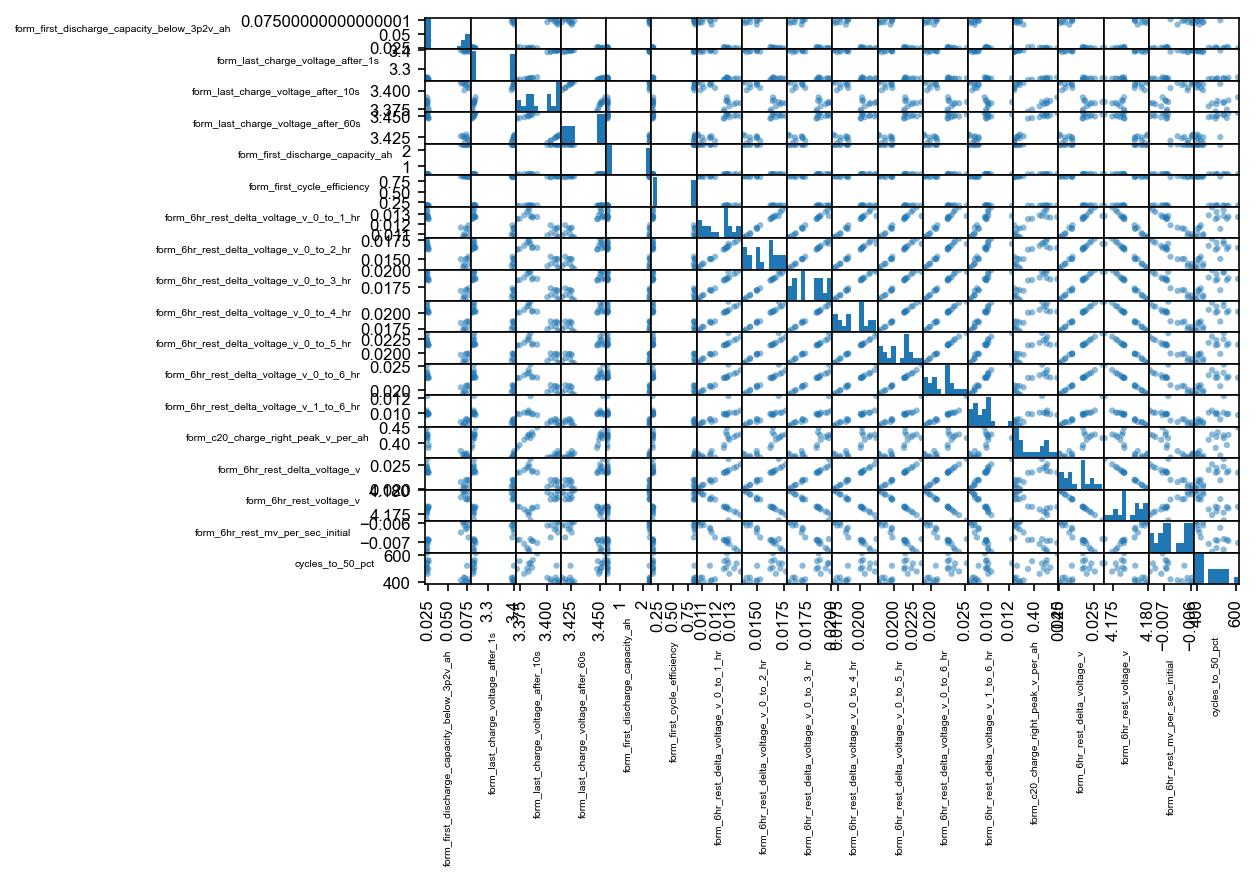

In [23]:
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 5
axes = scatter_matrix(df_form[high_corr_form_features + [yvar]])

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
OUTPUT_DIR = "code/imgs/"
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")

In [24]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
config_plots()

### with log

In [25]:
df_form_log = df_form.apply(lambda x: np.log(abs(x)))
df_form_log.describe()

form_first_discharge_capacity_below_3p2v_ah  \
count                                    19.000000   
mean                                     -3.198979   
std                                       0.564067   
min                                      -3.766923   
25%                                      -3.729466   
50%                                      -3.649625   
75%                                      -2.626924   
max                                      -2.553354   

       form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
count                          19.000000                           19.000000   
mean                            1.198703                            1.222002   
std                             0.023588                            0.004068   
min                             1.174555                            1.215440   
25%                             1.177094                            1.218782   
50%                             1.179177                            1.221083   
75%                             1.223027                            1.226052   
max                             1.224341                            1.227374   

       form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
count                           19.000000                      19.000000   
mean                             1.234841                       1.003142   
std                              0.004154                       0.012057   
min                              1.228971                       0.988929   
25%                              1.231004                       0.994866   
50%                              1.237599                       0.998291   
75%                              1.238623                       1.009378   
max                              1.239590                       1.037936   

       form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
count                         19.000000                    19.000000   
mean                           0.008368                    -0.994774   
std                            0.812216                     0.816364   
min                           -0.759595                    -1.784166   
25%                           -0.741329                    -1.746586   
50%                           -0.728661                    -1.722820   
75%                            0.838672                    -0.157774   
max                            0.850454                    -0.140043   

       form_final_discharge_capacity_ah  \
count                         19.000000   
mean                           0.860630   
std                            0.004333   
min                            0.854034   
25%                            0.858194   
50%                            0.860109   
75%                            0.862090   
max                            0.869140   

       form_6hr_rest_delta_voltage_v_0_to_1_hr  \
count                                19.000000   
mean                                 -4.416723   
std                                   0.078911   
min                                  -4.538118   
25%                                  -4.481583   
50%                                  -4.382669   
75%                                  -4.360943   
max                                  -4.293166   

       form_6hr_rest_delta_voltage_v_0_to_2_hr  \
count                                19.000000   
mean                                 -4.154705   
std                                   0.081232   
min                                  -4.287379   
25%                                  -4.219624   
50%                                  -4.119745   
75%                                  -4.093166   
max                                  -4.035049   

       form_6hr_rest_delta_voltage_v_0_to_3_hr  \
count                                19.000000   
mean                                 -4.027465   
std                      

In [26]:
df_form_log.corr()[yvar].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.994038
cycles_to_70_pct                               0.973508
cycles_to_80_pct                               0.973244
form_last_charge_voltage_after_60s             0.811610
form_c20_charge_right_peak_v_per_ah            0.773500
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.757980
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.757028
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.754870
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.748527
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.741700
form_6hr_rest_delta_voltage_v                  0.741018
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.726078
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.698246
form_6hr_rest_mv_per_sec_initial               0.671143
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.622037
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.565958
form_6hr_rest_delta_voltage_v_4_to_6_hr        0

## Training a regularized model

### Individual features

In [27]:
from sklearn.dummy import DummyRegressor

In [28]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
# train_and_test_model(df, form_features, yvar, to_plot=0, model=Ridge())
# model = ElasticNet(0.01, l1_ratio=0.5)
# train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
# print(model.coef_)

form_first_discharge_capacity_below_3p2v_ah       7.31 (2.58 std)
form_last_charge_voltage_after_1s                 7.18 (2.44 std)
form_last_charge_voltage_after_10s                8.57 (2.45 std)
form_last_charge_voltage_after_60s                7.18 (2.27 std)
form_first_charge_capacity_ah                     12.79 (3.20 std)
form_first_discharge_capacity_ah                  7.14 (2.38 std)
form_first_cycle_efficiency                       7.08 (2.35 std)
form_final_discharge_capacity_ah                  12.05 (3.64 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           8.43 (2.66 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           7.97 (2.76 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           7.80 (2.71 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           7.74 (2.57 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           7.77 (2.54 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           8.18 (2.56 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           9.33 (3.09 std)
form_6hr

with log

In [29]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000, log=True)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000, log=True)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")


form_first_discharge_capacity_below_3p2v_ah       7.09 (2.38 std)
form_last_charge_voltage_after_1s                 7.14 (2.45 std)
form_last_charge_voltage_after_10s                8.58 (2.61 std)
form_last_charge_voltage_after_60s                6.92 (2.27 std)
form_first_charge_capacity_ah                     12.83 (3.01 std)
form_first_discharge_capacity_ah                  7.04 (2.55 std)
form_first_cycle_efficiency                       7.21 (2.49 std)
form_final_discharge_capacity_ah                  11.93 (3.38 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           8.48 (2.72 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.01 (2.72 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           7.74 (2.69 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           7.84 (2.60 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           7.77 (2.43 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           8.04 (2.57 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           9.13 (3.38 std)
form_6hr

### Manual hyperparameter loops

In [30]:
def manual_gridsearch(features, yvar, log=False):
    gridsearch = {}
    def ridge(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Ridge(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Ridge"] = (alphas, list(map(ridge, alphas)))
    
    def lasso(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Lasso(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Lasso"] = (alphas, list(map(lasso, alphas)))
    
    def elastic_net(alpha, l1_ratio):
        return train_and_test_model(df, features, yvar, to_plot=0, 
                                    model=ElasticNet(alpha, l1_ratio=l1_ratio), log=log)["percent_error"]

    N = 10
    alphas = np.logspace(0,2,N)
    l1_ratios = np.linspace(0,1,N)
    errors = np.empty((N,N))
    for i, alpha in enumerate(alphas):
        print(i)
        for j, l1_ratio in enumerate(l1_ratios):
            errors[i,j] = elastic_net(alpha, l1_ratio)
    gridsearch["ElasticNet"] = (alphas, l1_ratios, errors)
    
    return gridsearch

In [31]:
gridsearch = manual_gridsearch(form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.275132872499853, tolerance: 7.755360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.60697788255402, tolerance: 4.285773333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.79214094166855, tolerance: 5.16476
  model = cd_fast.

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12827.058150118184, tolerance: 7.494000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14268.092754570183, tolerance: 6.615173333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8649.480200508244, tolerance: 4.85316
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12986.889393990195, tolerance: 7.816800000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13536.322747498014, tolerance: 6.610173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13145.199191593892, tolerance: 6.500773333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7183.934486700315, tolerance: 5.102693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13074.638392759256, tolerance: 7.990373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14370.025172871698, tolerance: 7.196560000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7270.939148858739, tolerance: 4.3676933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15338.094480599511, tolerance: 8.026773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12006.11254302874, tolerance: 7.373973333333333
  mode

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16430.44549941124, tolerance: 7.202800000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15175.767314232377, tolerance: 7.926133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14705.887719736831, tolerance: 7.466773333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14909.889530614559, tolerance: 7.277093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14628.251191876538, tolerance: 7.419773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13725.50080743806, tolerance: 7.846933333333335
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9350.417245148978, tolerance: 5.181773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13730.448138616173, tolerance: 7.469173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15400.231577203076, tolerance: 6.883559999999999
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8973.740133206828, tolerance: 4.673173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15244.430697712507, tolerance: 8.064773333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13102.395915695459, tolerance: 7.117493333333334
  mode

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16715.015635097297, tolerance: 8.028293333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16878.664720699864, tolerance: 7.167293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17976.20831013192, tolerance: 7.056039999999999
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15323.108854305945, tolerance: 8.378159999999998
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15507.850447484076, tolerance: 6.684933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15747.368893273804, tolerance: 7.23776
  model = cd_fa

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9999.689340034884, tolerance: 4.834040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10624.677681111516, tolerance: 6.004933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16890.059106218938, tolerance: 6.760533333333336
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16090.547076395877, tolerance: 7.0982933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15168.080445489197, tolerance: 7.554773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16647.54767669209, tolerance: 8.10656
  model = cd_fa

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18439.09335477789, tolerance: 7.541893333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17349.864107893925, tolerance: 6.904173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19269.233636711833, tolerance: 7.532960000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18198.427131269007, tolerance: 6.595440000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18989.95646338477, tolerance: 7.259693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17053.907245080543, tolerance: 5.889373333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18599.987811896935, tolerance: 7.320693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18055.651294806205, tolerance: 7.081893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11923.261826767932, tolerance: 5.512133333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19816.676149707837, tolerance: 7.391573333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10170.81476668776, tolerance: 4.6938
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19050.31186753128, tolerance: 6.689133333333333
  model = cd_fast.

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21163.627501020765, tolerance: 7.228373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21510.662607448226, tolerance: 7.499693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20911.001944884134, tolerance: 7.444373333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20497.997649045632, tolerance: 6.641933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20372.546323104732, tolerance: 7.692373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18163.515316697987, tolerance: 6.378973333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13019.670985586094, tolerance: 4.796093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22581.74580560188, tolerance: 7.509493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20704.97311539629, tolerance: 7.475533333333333
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19436.95219518504, tolerance: 6.351240000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20742.59910730126, tolerance: 6.39296
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20559.76849251766, tolerance: 7.547359999999998
  model = cd_fast.

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24534.80986789426, tolerance: 7.28604
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15293.638176335895, tolerance: 5.756373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14213.185667044718, tolerance: 4.4538
  model = cd_fast.enet_coor

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21718.272149591277, tolerance: 6.939093333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21823.9805640564, tolerance: 6.726360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22271.535597229726, tolerance: 6.414240000000001
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21830.966925170644, tolerance: 6.9052933333333355
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25137.12174627873, tolerance: 7.628773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24279.393825504398, tolerance: 7.5566
  model = cd_fas

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26619.33547452959, tolerance: 7.764373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18486.264560624517, tolerance: 5.443573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28441.892733168475, tolerance: 7.889360000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18428.556705062674, tolerance: 5.318040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25977.185906134684, tolerance: 7.475173333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24960.43688309982, tolerance: 6.66644
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16652.365056181996, tolerance: 4.868693333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18328.17199485959, tolerance: 5.718373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15764.486323631594, tolerance: 4.530173333333333
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28476.393994153386, tolerance: 7.6595733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28256.890124526777, tolerance: 7.910933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24524.16858667001, tolerance: 6.537693333333333
  mod

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30487.071837220257, tolerance: 8.071093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27520.54701529008, tolerance: 6.882240000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29875.31696270128, tolerance: 7.6821600000000005
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30246.38097398657, tolerance: 7.685333333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26186.12041968964, tolerance: 6.201373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29660.488130026453, tolerance: 7.546693333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19597.433482311953, tolerance: 5.3053333333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29144.96753085385, tolerance: 7.5383733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25811.14698538185, tolerance: 6.257893333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28067.937695061184, tolerance: 6.863573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27168.056117757773, tolerance: 6.817573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19283.099570820574, tolerance: 5.11224
  model = cd_fa

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31944.274129717058, tolerance: 7.498560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31754.046125315588, tolerance: 7.429093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31678.497480380975, tolerance: 7.3230933333333335
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28763.225515026297, tolerance: 6.610173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26958.547910563717, tolerance: 6.117533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29837.243426200475, tolerance: 6.863093333333335
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21519.714188022346, tolerance: 5.259133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32746.75342736978, tolerance: 7.764373333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32153.414693302395, tolerance: 7.477560000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23540.498332785377, tolerance: 5.775733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24594.511602038725, tolerance: 5.927493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30135.625395955878, tolerance: 6.912093333333334
  mod

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21095.60271199118, tolerance: 4.78284
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25104.854811804562, tolerance: 5.721093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22644.300664597373, tolerance: 5.140293333333333
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33098.267969194276, tolerance: 7.4118933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33567.80465959652, tolerance: 7.401173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31064.992482556176, tolerance: 6.812573333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36481.40551391086, tolerance: 8.081533333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34110.88909941441, tolerance: 7.582960000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762.577204981168, tolerance: 7.314773333333332
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31386.587807544653, tolerance: 6.922693333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21647.470792963813, tolerance: 4.799573333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22138.339751313724, tolerance: 5.0388
  model = cd_fas

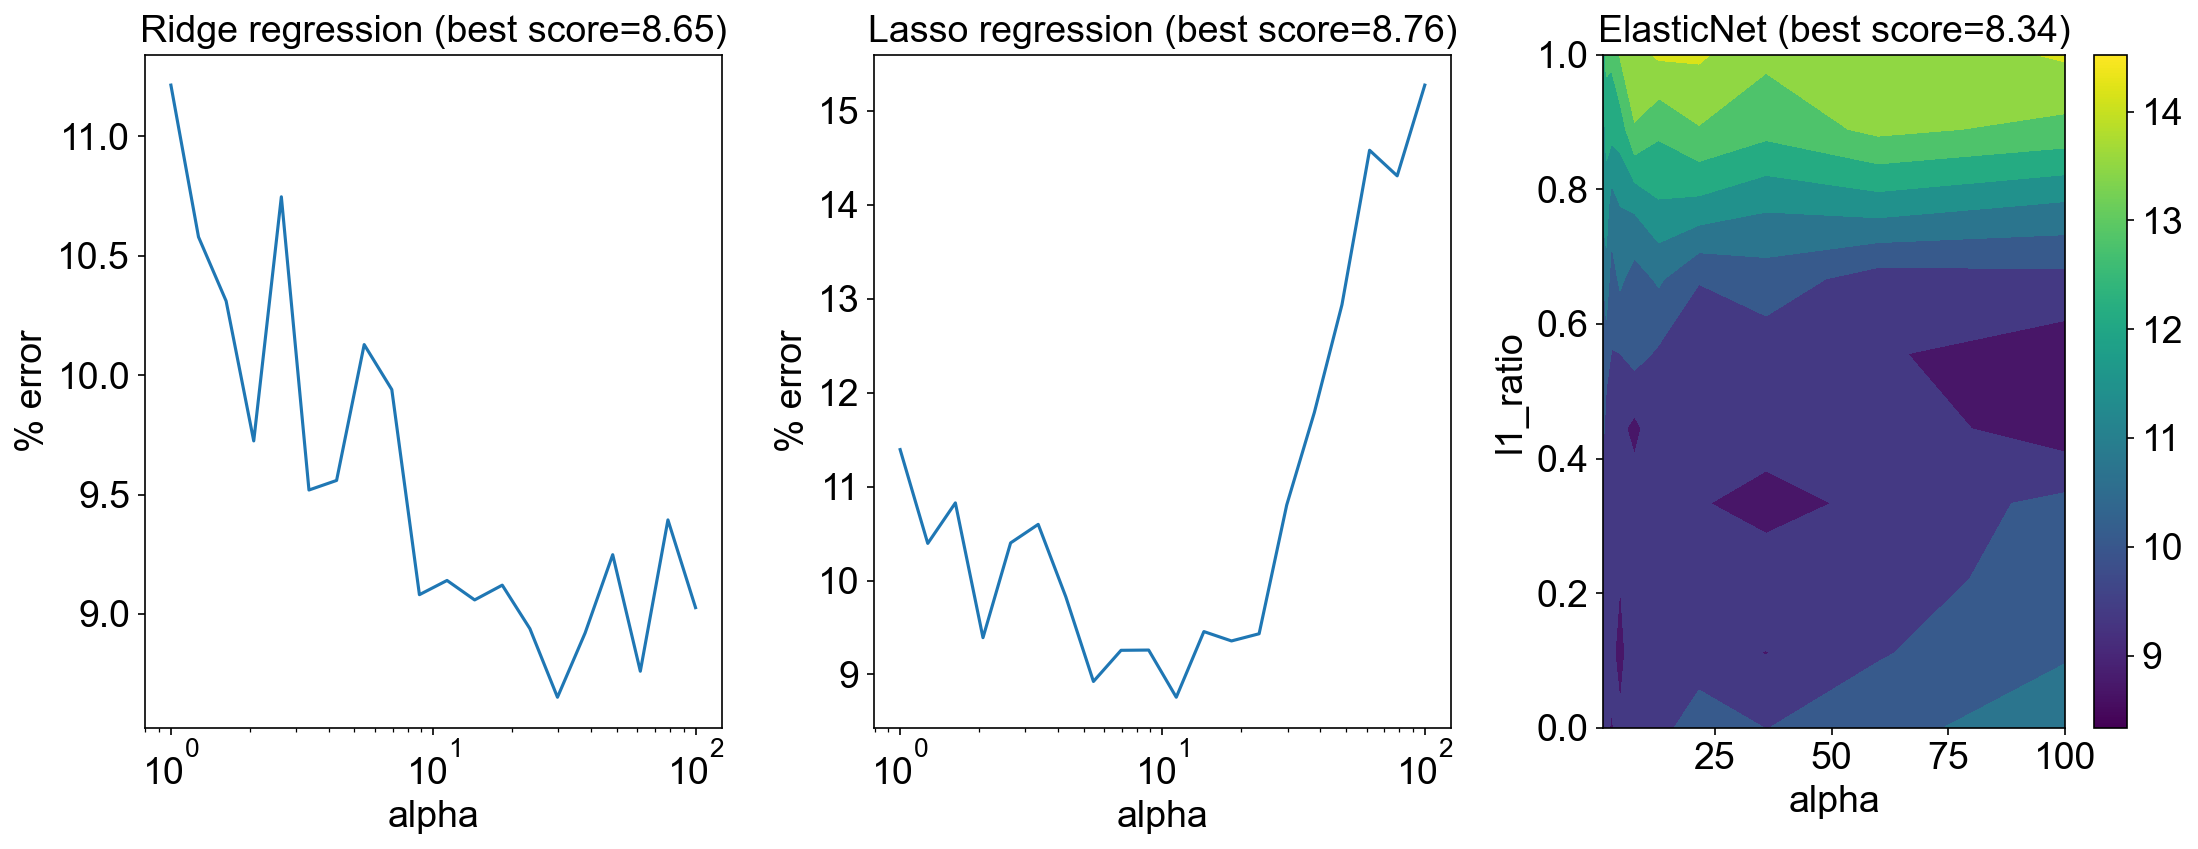

In [32]:
def plot_gridsearch(gridsearch):
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    ax = axes[0]
    ax.semilogx(*gridsearch["Ridge"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Ridge regression (best score={np.min(gridsearch['Ridge'][1]):.2f})")

    ax = axes[1]
    ax.semilogx(*gridsearch["Lasso"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Lasso regression (best score={np.min(gridsearch['Lasso'][1]):.2f})")

    ax = axes[2]
    ax.contourf(*gridsearch["ElasticNet"])
    ax.set_title(f"ElasticNet (best score={np.min(gridsearch['ElasticNet'][2]):.2f})")
    ax.set_xlabel("alpha")
    ax.set_ylabel("l1_ratio")
    vmin = np.min(gridsearch['ElasticNet'][2])
    vmax = np.max(gridsearch['ElasticNet'][2])
    plt.colorbar(cm.ScalarMappable(colors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)

    fig.tight_layout()
    return fig

fig = plot_gridsearch(gridsearch)
fig.savefig(OUTPUT_DIR + "manual_gridsearch.pdf")

### Manual, high corr features

In [33]:
gridsearch_highcorr = manual_gridsearch(high_corr_form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.400128344950645, tolerance: 5.514773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.916257200182372, tolerance: 6.055733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.840116088927971, tolerance: 5.816693333333333
  mode

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15992.341035456378, tolerance: 7.1417600000000006
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14367.48539455641, tolerance: 7.066933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15274.362343586665, tolerance: 7.052760000000001
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14855.435161622128, tolerance: 6.985573333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12749.559065595113, tolerance: 7.584960000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9019.44153368606, tolerance: 5.512133333333333
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12401.792995731837, tolerance: 7.078133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8001.822561147929, tolerance: 4.259373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13217.315207738713, tolerance: 7.917573333333334
  mode

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14792.34868402866, tolerance: 6.1432400000000005
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16712.472863452847, tolerance: 7.509840000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14906.764673335187, tolerance: 7.215493333333332
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15898.335187506558, tolerance: 7.3925333333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16304.522596405392, tolerance: 6.265493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14902.218264855332, tolerance: 7.52736
  model = cd_f

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17119.870895095934, tolerance: 7.4644933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8703.737382687494, tolerance: 5.478773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16451.4629477145, tolerance: 7.233493333333333
  model

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14954.170249745956, tolerance: 6.77844
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15578.530332410324, tolerance: 5.8386000000000005
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14398.55766002166, tolerance: 7.424960000000001
  model = cd_fa

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9867.996604025106, tolerance: 5.061493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17620.56823409034, tolerance: 6.7449600000000025
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15776.736573380764, tolerance: 7.649973333333334
  mode

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17236.395865123115, tolerance: 6.9498933333333355
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19760.676490662947, tolerance: 7.328293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19190.275275575113, tolerance: 7.631573333333334
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18075.993005394514, tolerance: 7.243733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18910.16211584942, tolerance: 7.098293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19817.37981296778, tolerance: 7.195200000000001
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.601080357106184, tolerance: 5.851893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5422994766759075, tolerance: 4.85316
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21024.27984975061, tolerance: 6.947893333333335
  model = cd_fast

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14593.54955354559, tolerance: 5.415173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20970.10442077957, tolerance: 7.479733333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21856.494349615736, tolerance: 7.56896
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18823.963464007742, tolerance: 6.409560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20383.062462840477, tolerance: 7.012773333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21002.261787438616, tolerance: 6.879933333333335
  mod

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24194.655325727075, tolerance: 6.973173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17341.64179839816, tolerance: 5.341173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23845.072855409904, tolerance: 7.493893333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22637.68140993736, tolerance: 6.9516
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23258.1465124422, tolerance: 6.485760000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23176.07453465773, tolerance: 6.747373333333334
  model = cd_fast.en

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24086.316078732678, tolerance: 7.518159999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24568.51359821053, tolerance: 7.901360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25209.087300416908, tolerance: 7.413493333333334
  mode

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28336.820091466776, tolerance: 7.590093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27322.9081572805, tolerance: 7.597693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25070.45375165291, tolerance: 6.469533333333334
  model 

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26616.22074706146, tolerance: 7.2637333333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27159.538322120163, tolerance: 7.652773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17339.283535109436, tolerance: 4.855693333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17903.57080668191, tolerance: 5.225893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26316.025146216405, tolerance: 7.420373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27932.038333606513, tolerance: 8.054293333333334
  mode

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27319.40052091824, tolerance: 6.77844
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22351.041244029573, tolerance: 5.653573333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28806.59545367195, tolerance: 6.896133333333333
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28777.445607414153, tolerance: 6.937493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29293.16992678432, tolerance: 7.243733333333331
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28903.743489768836, tolerance: 7.223173333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31790.56030685236, tolerance: 7.888693333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20111.60698219829, tolerance: 5.10096
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30363.144080500653, tolerance: 7.448640000000001
  model = cd_fast

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30726.39316399247, tolerance: 6.9866
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29411.50735734511, tolerance: 6.77844
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24304.24766535717, tolerance: 5.804133333333333
  model = cd_fast.enet_coordi

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30282.510125613324, tolerance: 6.908093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34007.77074560822, tolerance: 7.781093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28075.520995761035, tolerance: 6.331293333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31319.60697639718, tolerance: 7.0785333333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32871.724962592205, tolerance: 7.575893333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32245.945471616567, tolerance: 7.39344
  model = cd_fa

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24264.562925150778, tolerance: 5.337840000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23621.582168734254, tolerance: 5.181773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35323.88281053139, tolerance: 7.794240000000003
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35244.11867945081, tolerance: 7.674693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32520.144380477577, tolerance: 7.11024
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30689.75077121079, tolerance: 6.64284
  model = cd_fast.enet_coor

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23150.25148794672, tolerance: 5.09196
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30657.38151351149, tolerance: 6.619773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33042.40097799002, tolerance: 7.222693333333334
  model = cd_fast.

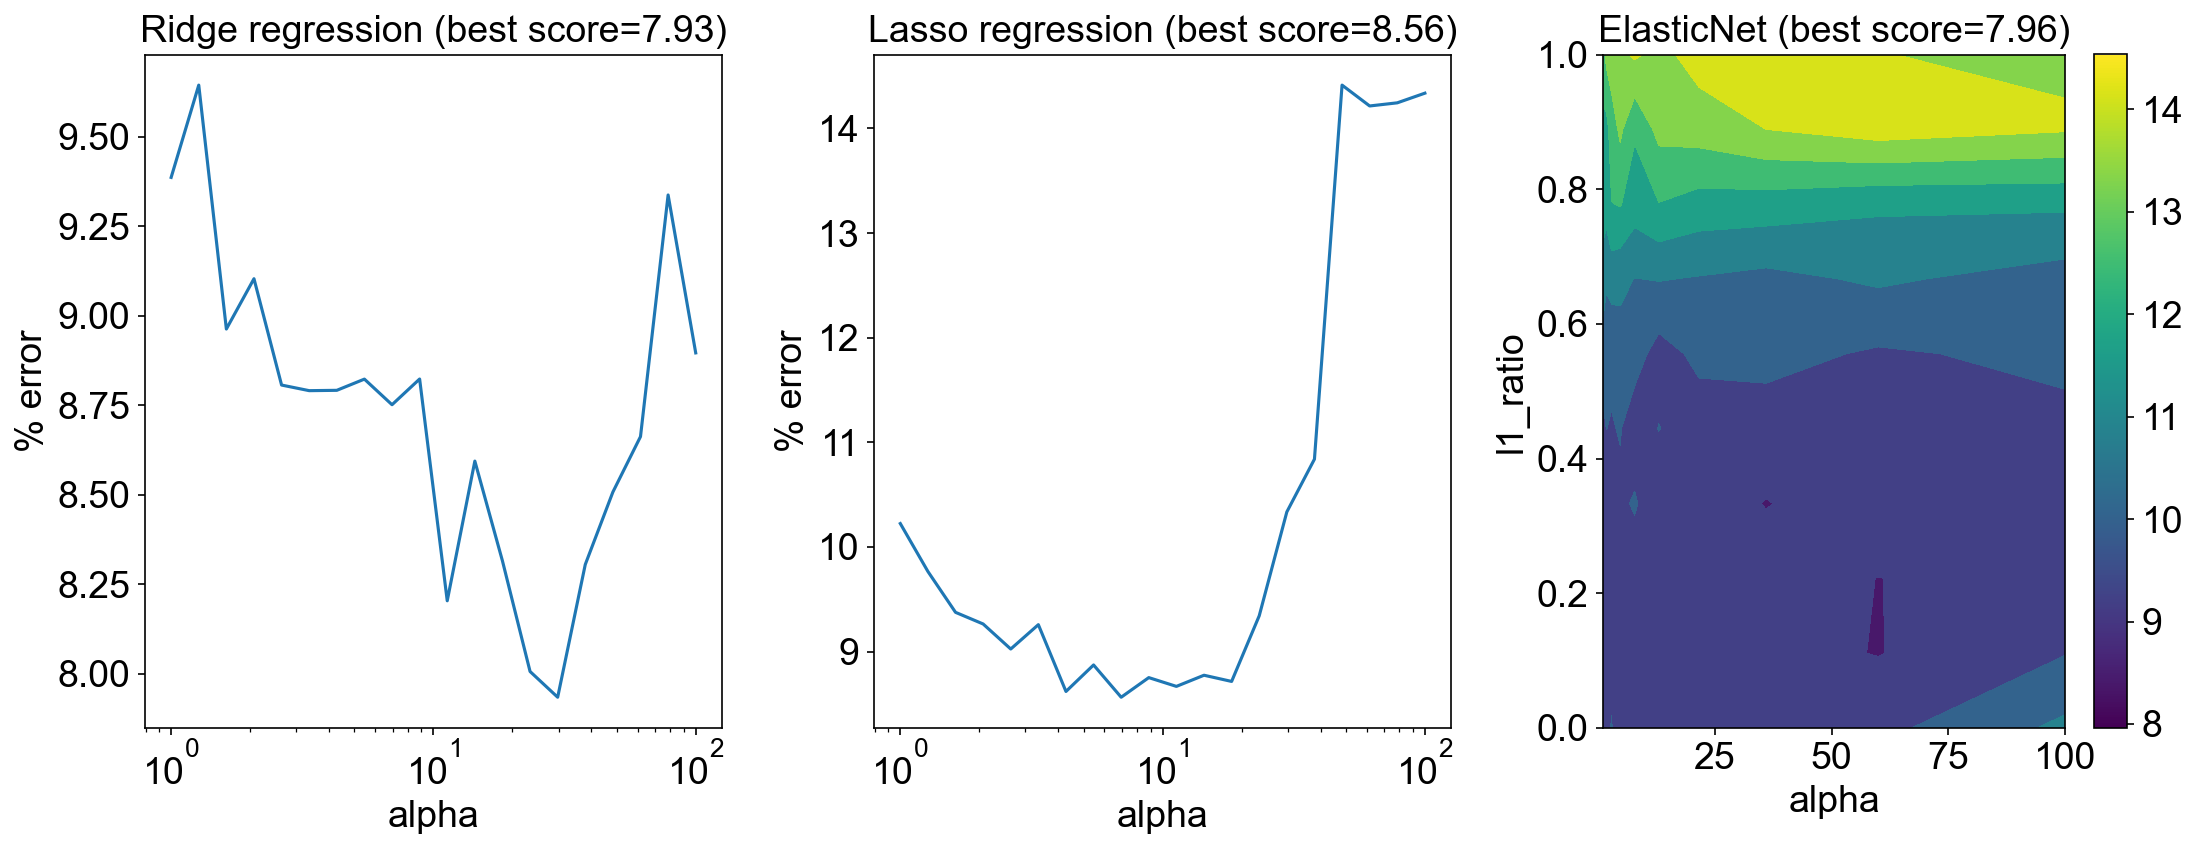

In [34]:
fig = plot_gridsearch(gridsearch_highcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_highcorr.pdf")

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24666.028305916483, tolerance: 7.693973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26220.460907921668, tolerance: 8.366533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24968.823261613128, tolerance: 7.534693333333332
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14872.329799040006, tolerance: 4.476373333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17077.95127021072, tolerance: 5.220693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24429.657646766973, tolerance: 7.148133333333333
  mode

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26667.951949379807, tolerance: 6.92744
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30431.630735902556, tolerance: 8.372973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29053.93428762313, tolerance: 8.084333333333333
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26036.27185328893, tolerance: 6.79264
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26098.070002438733, tolerance: 6.902933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26813.501891293192, tolerance: 7.127573333333334
  model = cd_fas

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27730.37491150488, tolerance: 6.814093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31102.525346874787, tolerance: 7.568960000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28176.624911094405, tolerance: 6.746759999999999
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29314.93738407613, tolerance: 7.036160000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21401.156636535437, tolerance: 5.338639999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20506.2667664264, tolerance: 5.021373333333333
  model 

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19376.986604122132, tolerance: 4.540733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21540.159792351245, tolerance: 4.912973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32911.27909645159, tolerance: 7.543573333333334
  mode

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23032.806224436084, tolerance: 4.995133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34174.42056377217, tolerance: 7.418159999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23495.323337344824, tolerance: 5.189493333333335
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36073.4187281597, tolerance: 7.887733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26499.426955908275, tolerance: 5.675933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23704.862354749515, tolerance: 5.147133333333333
  model

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34969.37550914288, tolerance: 7.371360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32318.078141490492, tolerance: 6.759173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35771.02770655452, tolerance: 7.518560000000001
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32084.0056717623, tolerance: 6.761493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33200.29017395298, tolerance: 6.9467733333333355
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35320.48452308759, tolerance: 7.459733333333335
  model 

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30886.92427295762, tolerance: 6.351240000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37311.35504828314, tolerance: 7.685933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24796.947665757612, tolerance: 5.120373333333332
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21950.304958521276, tolerance: 4.533693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37776.38985472355, tolerance: 7.795093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39465.17012417045, tolerance: 8.179733333333333
  model

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39678.39542660766, tolerance: 8.084293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37401.67594548305, tolerance: 7.6315733333333355
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32357.398165046343, tolerance: 6.5824933333333355
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33669.25276169572, tolerance: 6.850733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38775.095662958505, tolerance: 7.907893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36932.745709488634, tolerance: 7.541173333333333
  mode

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32366.16975243947, tolerance: 6.537693333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24893.225720715327, tolerance: 5.0388
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28050.98639664533, tolerance: 5.678893333333334
  model = cd_fast.

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35204.340636307694, tolerance: 7.111973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30459.953382206746, tolerance: 6.150493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36847.01616088323, tolerance: 7.459733333333336
  mode

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26126.732268105716, tolerance: 5.268000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24418.48391909395, tolerance: 4.917173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39174.895010739936, tolerance: 7.889360000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36670.98850665661, tolerance: 7.3825600000000025
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36070.86434743964, tolerance: 7.2596933333333356
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34159.80894396404, tolerance: 6.876693333333334
  mode

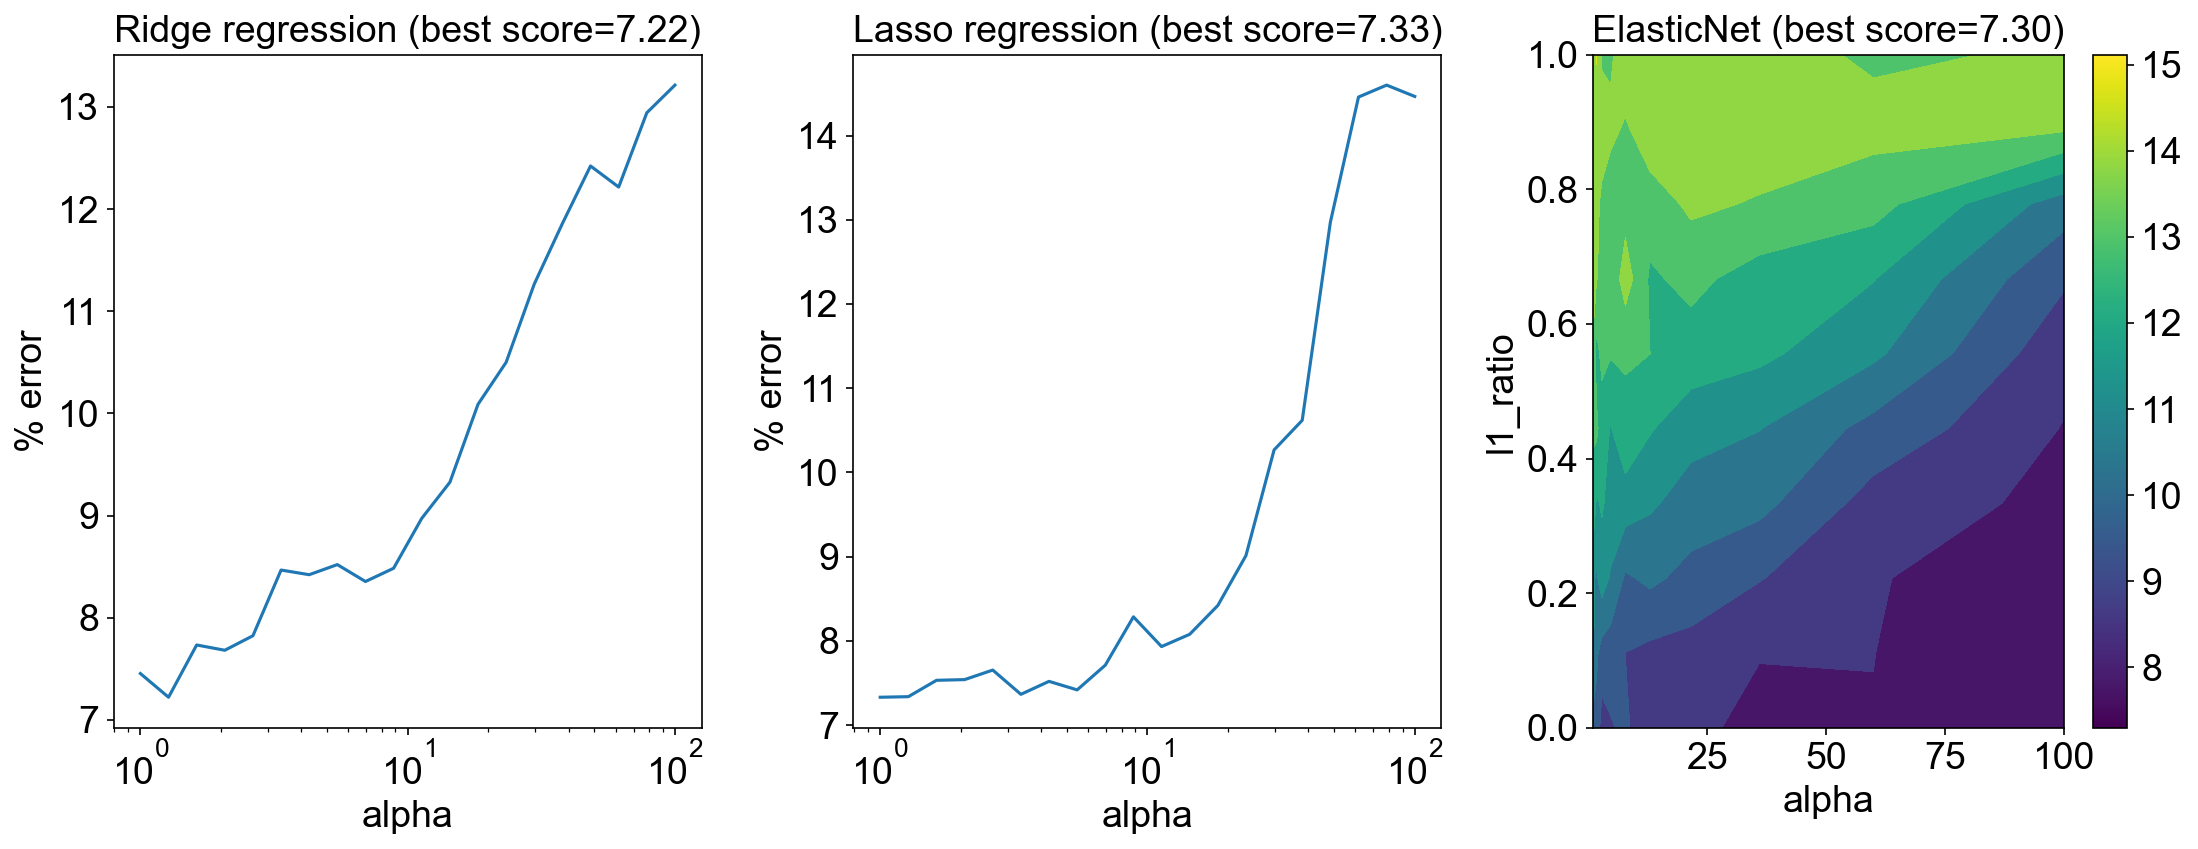

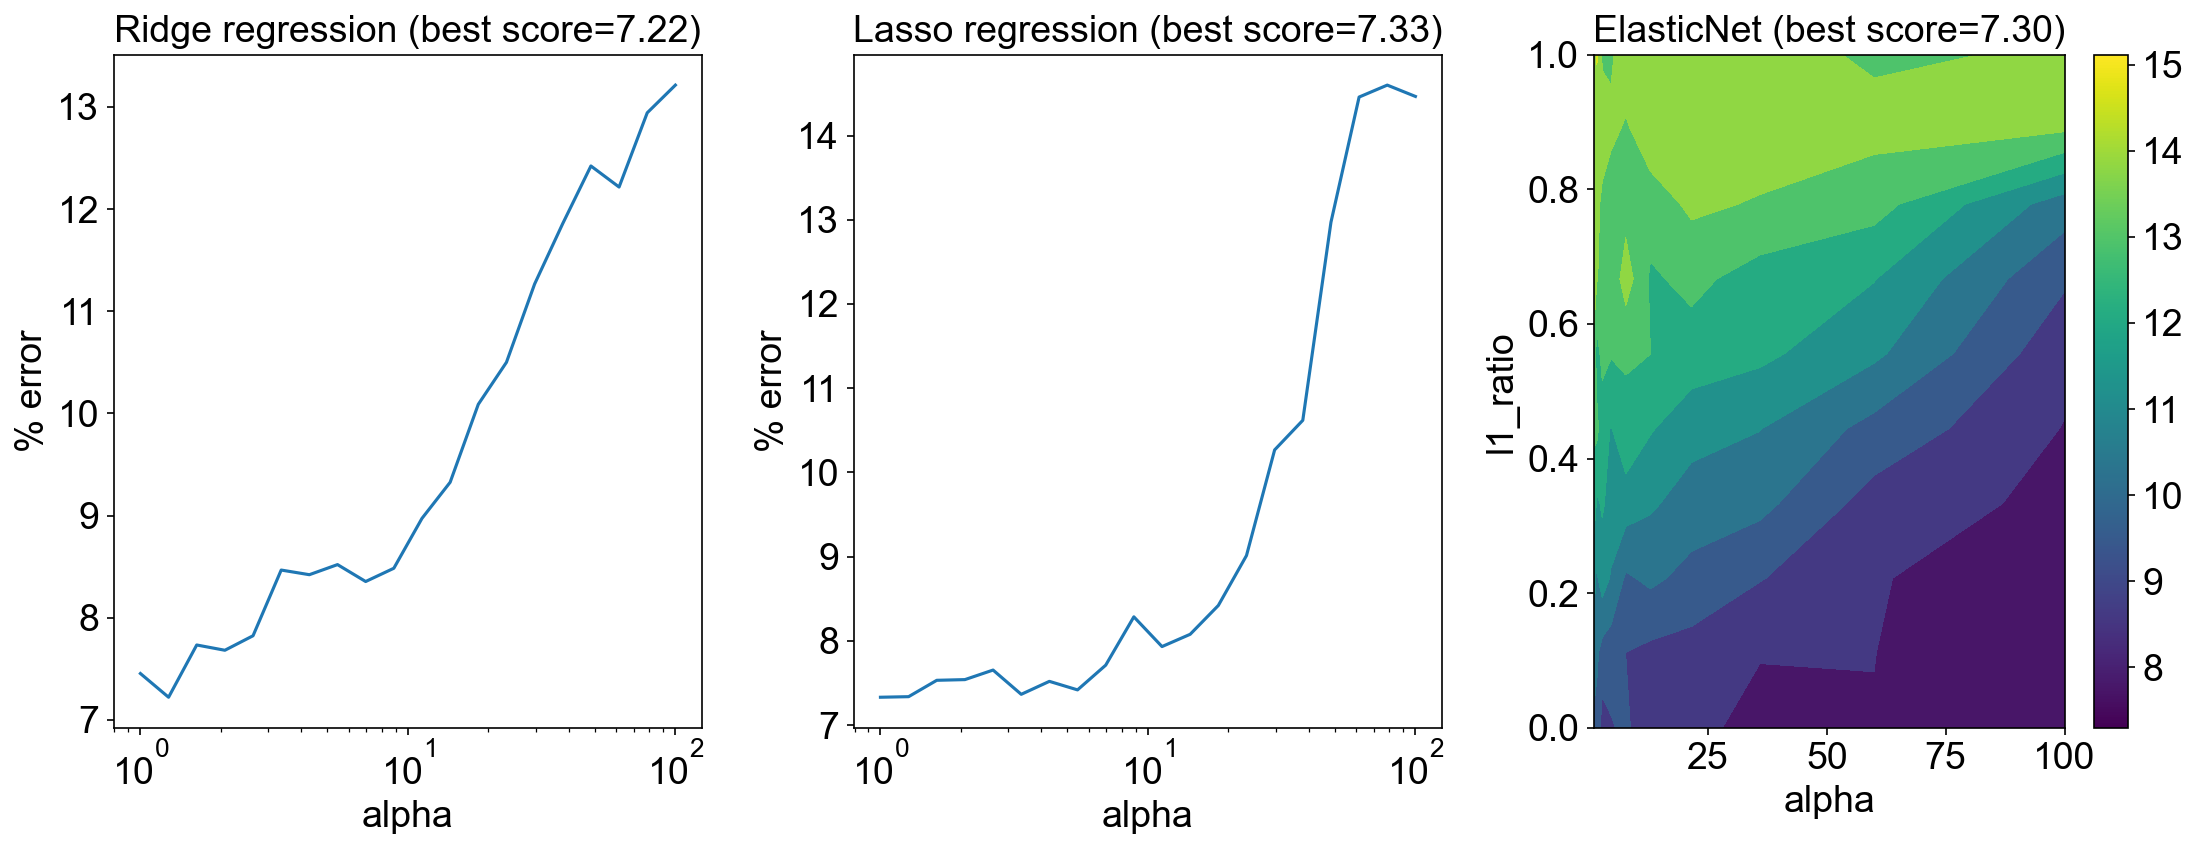

In [35]:
plot_gridsearch(manual_gridsearch("form_first_discharge_capacity_ah", yvar70))

### Manual, very high corr

In [36]:
gridsearch_veryhighcorr = manual_gridsearch(very_high_corr_form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.877154136745958, tolerance: 5.322933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.814918631163891, tolerance: 5.341173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.837080057764979, tolerance: 6.013173333333334
  model 

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.881015328955982, tolerance: 5.5894933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4870915894753125, tolerance: 5.6659733333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.815752416243413, tolerance: 5.828640000000001
  mod

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16349.50299809633, tolerance: 7.606400000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15124.074912142623, tolerance: 7.142693333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12191.345628961357, tolerance: 6.936693333333333
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15100.16101282368, tolerance: 7.609933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14226.66782895274, tolerance: 7.1235333333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14780.839990596265, tolerance: 7.3931733333333325
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.122405917512879, tolerance: 5.220693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.939699798271249, tolerance: 5.008439999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.764323849674838, tolerance: 5.418493333333334
  model 

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18385.203499149593, tolerance: 7.405893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15819.486362252237, tolerance: 7.151373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14200.331380806962, tolerance: 8.090133333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16599.192741245613, tolerance: 6.619173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16800.086094968872, tolerance: 7.388960000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16787.8850468799, tolerance: 7.4075733333333345
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.483839530617843, tolerance: 5.00844
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.280201527741156, tolerance: 5.480293333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.577926968891916, tolerance: 4.8074
  model = cd_fast.enet_coordi

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11344.747301610192, tolerance: 4.144573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20178.733475149136, tolerance: 8.014640000000002
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18600.600114375513, tolerance: 6.481133333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18412.883250057097, tolerance: 7.239573333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18303.122480968093, tolerance: 7.2395733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14704.242326510986, tolerance: 5.839573333333334
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.862017318331709, tolerance: 4.867133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0995414158423955, tolerance: 4.5654
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.507084252363711, tolerance: 5.450893333333334
  model = cd_fast.

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23518.48062641534, tolerance: 7.897573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23519.836853697074, tolerance: 7.930293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22327.510409026472, tolerance: 7.142693333333336
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23156.554858868025, tolerance: 7.2738933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23240.1006737318, tolerance: 8.422493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15646.975770790057, tolerance: 4.907133333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.6567588676934975, tolerance: 5.492373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.171801536916973, tolerance: 6.135573333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.084480316250847, tolerance: 4.9683600000000006
  mode

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19000.433169744814, tolerance: 5.318040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26720.457493183872, tolerance: 7.827893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15323.385697158932, tolerance: 4.328893333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24829.2160037628, tolerance: 6.964533333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27045.41749880481, tolerance: 8.029173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22489.483824984007, tolerance: 6.1151333333333335
  model

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21491.631569426223, tolerance: 5.443573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31613.49124065722, tolerance: 8.17016
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28222.49928912115, tolerance: 7.021533333333333
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27452.078834652617, tolerance: 6.902933333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29280.42331837036, tolerance: 7.428560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26641.400933157252, tolerance: 7.023360000000001
  mode

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26381.59932138274, tolerance: 6.147893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20828.945926447053, tolerance: 5.008293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29869.91165083665, tolerance: 7.009973333333333
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32112.077805522076, tolerance: 7.657493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23549.474356124985, tolerance: 5.56536
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18705.819255554077, tolerance: 4.416973333333334
  model = cd_fa

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20843.582639880035, tolerance: 4.589160000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23267.965833609436, tolerance: 5.140093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30289.94888443794, tolerance: 6.622040000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30645.40269910951, tolerance: 6.773093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22515.408352107865, tolerance: 4.9683600000000006
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31125.22015661609, tolerance: 6.812973333333334
  mode

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29754.33377528964, tolerance: 6.319933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34515.591114144045, tolerance: 7.336533333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32604.176744303062, tolerance: 6.97584
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28702.008986149875, tolerance: 6.0642000000000005
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30459.019911820567, tolerance: 6.502800000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19309.91066615145, tolerance: 4.114173333333334
  mod

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35761.01049062089, tolerance: 7.428373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26475.705972198222, tolerance: 5.50344
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21625.94855077686, tolerance: 4.502973333333335
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36264.83317168379, tolerance: 7.561893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37633.356209668105, tolerance: 7.833600000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20045.14026753938, tolerance: 4.1631599999999995
  mode

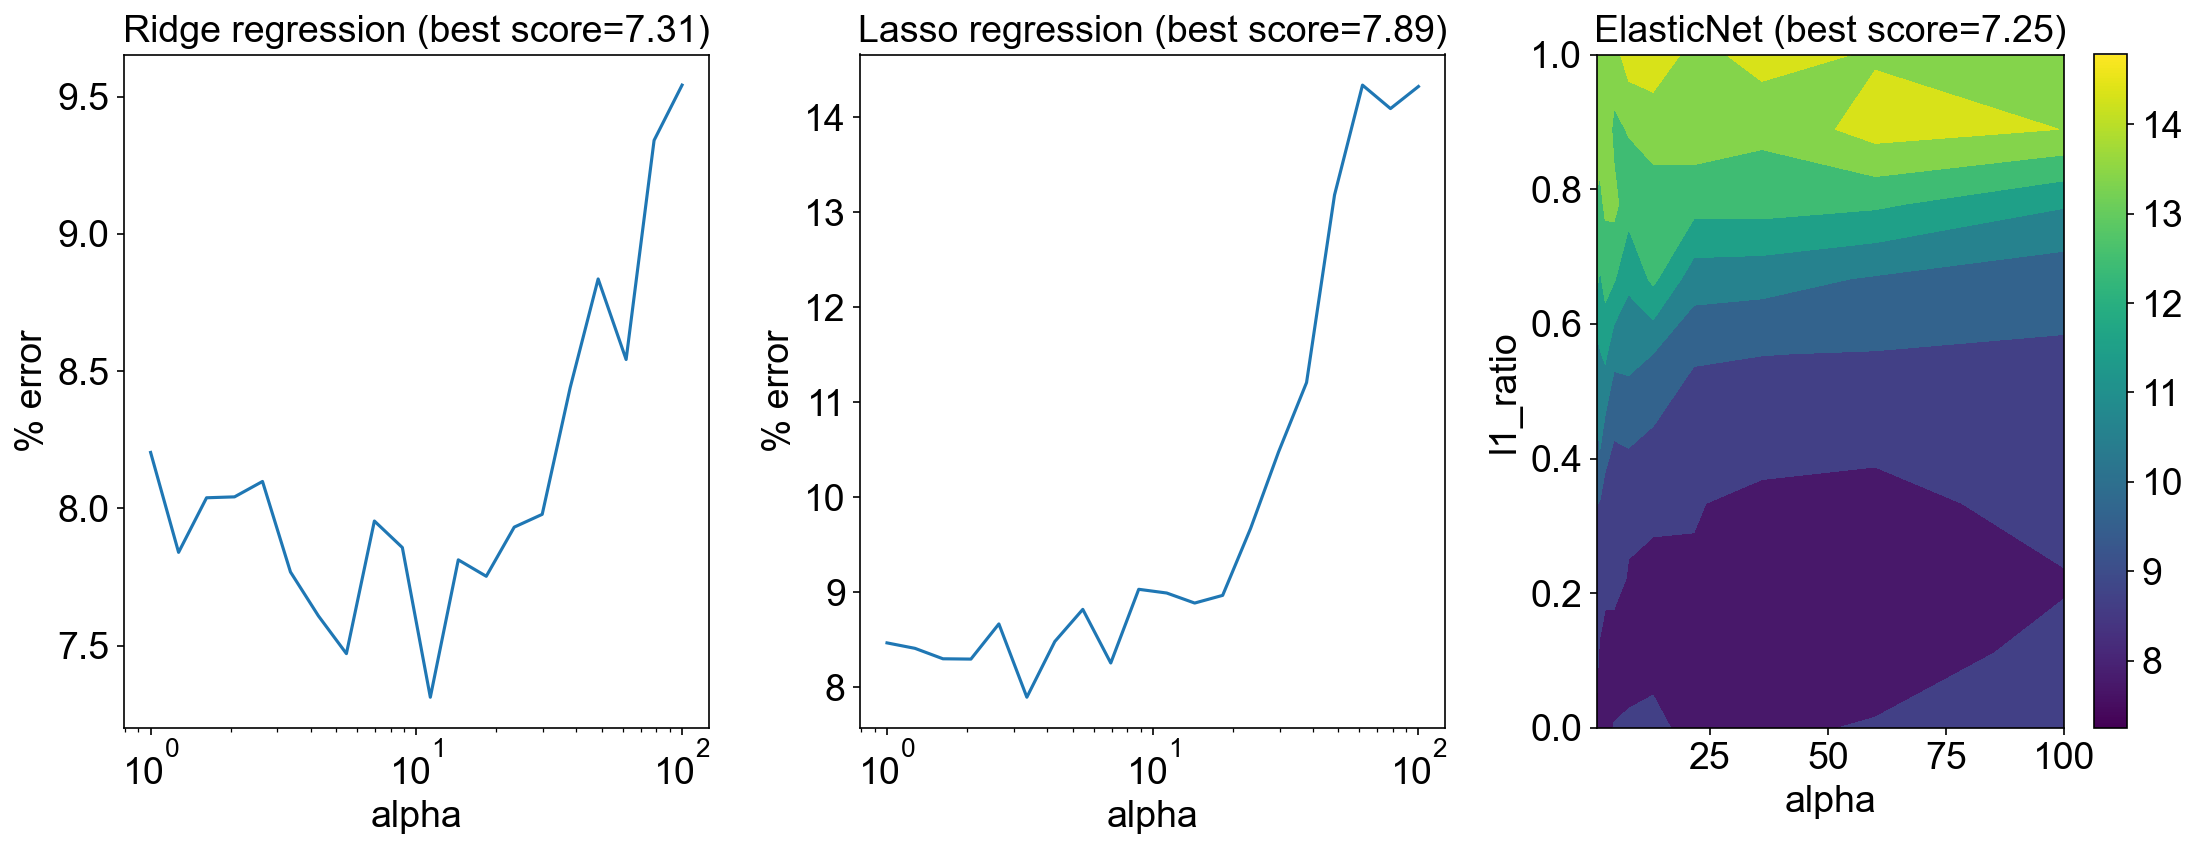

In [37]:
fig = plot_gridsearch(gridsearch_veryhighcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_veryhighcorr.pdf")

In [38]:
yvar

'cycles_to_50_pct'

## Printing lots of models

In [39]:
def print_model(model, yvar, **kwargs):
    print(model)
    print("Label: ", yvar)
    for f in very_high_corr_form_features:
        out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000,
                                  **kwargs)
        print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
    out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000,
                              **kwargs)
    print(f"{'Dummy regressor (predict mean)':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'very high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'all':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    # out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=Lasso(5), num_experiments=1000)
    # print(f"{'Lasso(5), very high corr':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    

In [40]:
print_model(ElasticNet(alpha=50, l1_ratio=0.3), yvar70)

ElasticNet(alpha=50, l1_ratio=0.3)
Label:  cycles_to_70_pct
form_first_discharge_capacity_below_3p2v_ah       7.77 (2.52 std)
form_last_charge_voltage_after_1s                 7.47 (2.48 std)
form_last_charge_voltage_after_60s                7.76 (2.76 std)
form_first_discharge_capacity_ah                  7.44 (2.46 std)
form_first_cycle_efficiency                       7.45 (2.40 std)
form_c20_charge_right_peak_v_per_ah               8.39 (2.70 std)
Dummy regressor (predict mean)          14.20 (3.92 std)
very high corr                          13.24 (3.93 std)
high corr                               12.14 (3.75 std)
all                                     12.01 (3.57 std)


In [41]:
print_model(Ridge(10), yvar50)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.20 (2.54 std)
form_last_charge_voltage_after_1s                 7.24 (2.36 std)
form_last_charge_voltage_after_60s                7.22 (2.32 std)
form_first_discharge_capacity_ah                  7.10 (2.41 std)
form_first_cycle_efficiency                       7.20 (2.28 std)
form_c20_charge_right_peak_v_per_ah               8.15 (2.27 std)
Dummy regressor (predict mean)          12.82 (3.07 std)
very high corr                          7.46 (2.28 std)
high corr                               7.56 (2.31 std)
all                                     9.02 (2.73 std)


In [42]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=False)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.24 (2.57 std)
form_last_charge_voltage_after_1s                 7.17 (2.37 std)
form_last_charge_voltage_after_60s                7.15 (2.35 std)
form_first_discharge_capacity_ah                  7.01 (2.30 std)
form_first_cycle_efficiency                       6.97 (2.36 std)
form_c20_charge_right_peak_v_per_ah               7.97 (2.26 std)
Dummy regressor (predict mean)          12.69 (3.11 std)
very high corr                          7.31 (2.24 std)
high corr                               7.70 (2.32 std)
all                                     8.82 (2.63 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.56 (2.54 std)
form_last_charge_voltage_after_1s                 7.44 (2.56 std)
form_last_charge_voltage_after_60s                7.35 (2.53 std)
form_first_discharge_capacity_ah                  7.39 (2.51 std)
form_first_cycle_efficiency      

In [43]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.17 (2.38 std)
form_last_charge_voltage_after_1s                 7.08 (2.38 std)
form_last_charge_voltage_after_60s                6.88 (2.23 std)
form_first_discharge_capacity_ah                  7.07 (2.39 std)
form_first_cycle_efficiency                       7.05 (2.37 std)
form_c20_charge_right_peak_v_per_ah               7.93 (2.17 std)
Dummy regressor (predict mean)          12.97 (3.01 std)
very high corr                          7.27 (2.28 std)
high corr                               7.45 (2.45 std)
all                                     8.77 (2.49 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.57 (2.58 std)
form_last_charge_voltage_after_1s                 7.28 (2.44 std)
form_last_charge_voltage_after_60s                7.29 (2.52 std)
form_first_discharge_capacity_ah                  7.37 (2.62 std)
form_first_cycle_efficiency      

In [44]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, square=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.65 (2.60 std)
form_last_charge_voltage_after_1s                 7.33 (2.45 std)
form_last_charge_voltage_after_60s                7.47 (2.49 std)
form_first_discharge_capacity_ah                  7.16 (2.40 std)
form_first_cycle_efficiency                       7.18 (2.34 std)
form_c20_charge_right_peak_v_per_ah               8.23 (2.28 std)
Dummy regressor (predict mean)          12.88 (3.29 std)
very high corr                          7.59 (2.26 std)
high corr                               7.74 (2.45 std)
all                                     9.52 (2.84 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.64 (2.82 std)
form_last_charge_voltage_after_1s                 7.41 (2.43 std)
form_last_charge_voltage_after_60s                7.57 (2.59 std)
form_first_discharge_capacity_ah                  7.45 (2.61 std)
form_first_cycle_efficiency      

In [45]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, sqrt=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.12 (2.58 std)
form_last_charge_voltage_after_1s                 7.24 (2.48 std)
form_last_charge_voltage_after_60s                7.12 (2.33 std)
form_first_discharge_capacity_ah                  7.07 (2.37 std)
form_first_cycle_efficiency                       7.04 (2.38 std)
form_c20_charge_right_peak_v_per_ah               7.98 (2.27 std)
Dummy regressor (predict mean)          12.64 (3.02 std)
very high corr                          7.39 (2.30 std)
high corr                               7.61 (2.30 std)
all                                     8.74 (2.47 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.34 (2.54 std)
form_last_charge_voltage_after_1s                 7.41 (2.60 std)
form_last_charge_voltage_after_60s                7.29 (2.52 std)
form_first_discharge_capacity_ah                  7.20 (2.55 std)
form_first_cycle_efficiency      

## PCA

In [46]:
df_form.corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
cycles_to_70_pct                              -0.822596
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
cycles_to_80_pct                              -0.788770
cycles_to_60_pct                              -0.785245
cycles_to_50_pct                              -0.782680
form_6hr_rest_delta_voltage_v_2_to_6_hr       -0.692257
form_6hr_rest_delta_voltage_v_3_to_6_hr       -0.634634
form_6hr_rest_delta_voltage_v_4_to_6_hr       -0.598132
form_6hr_rest_delta_voltage_v_5_to_6_hr       -0

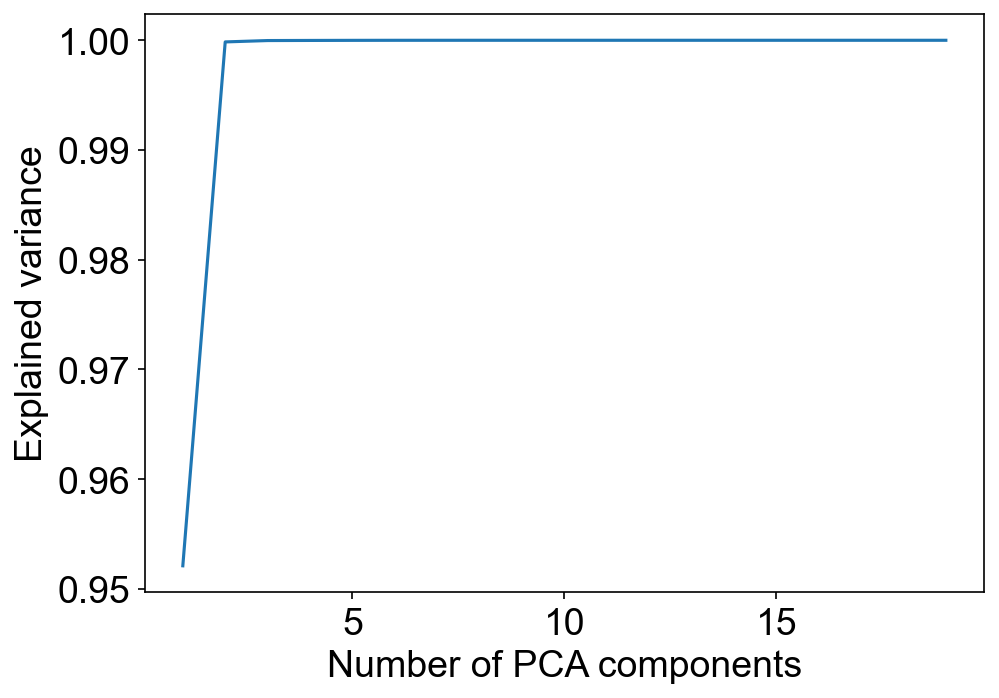

In [47]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_form[form_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1,len(cumsum)+1),cumsum)
ax.set_xlabel("Number of PCA components")
ax.set_ylabel("Explained variance")
fig.savefig(OUTPUT_DIR + "pca.pdf")

In [48]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = very_high_corr_form_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

7.557443477501498

## Understanding the model

See https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html 

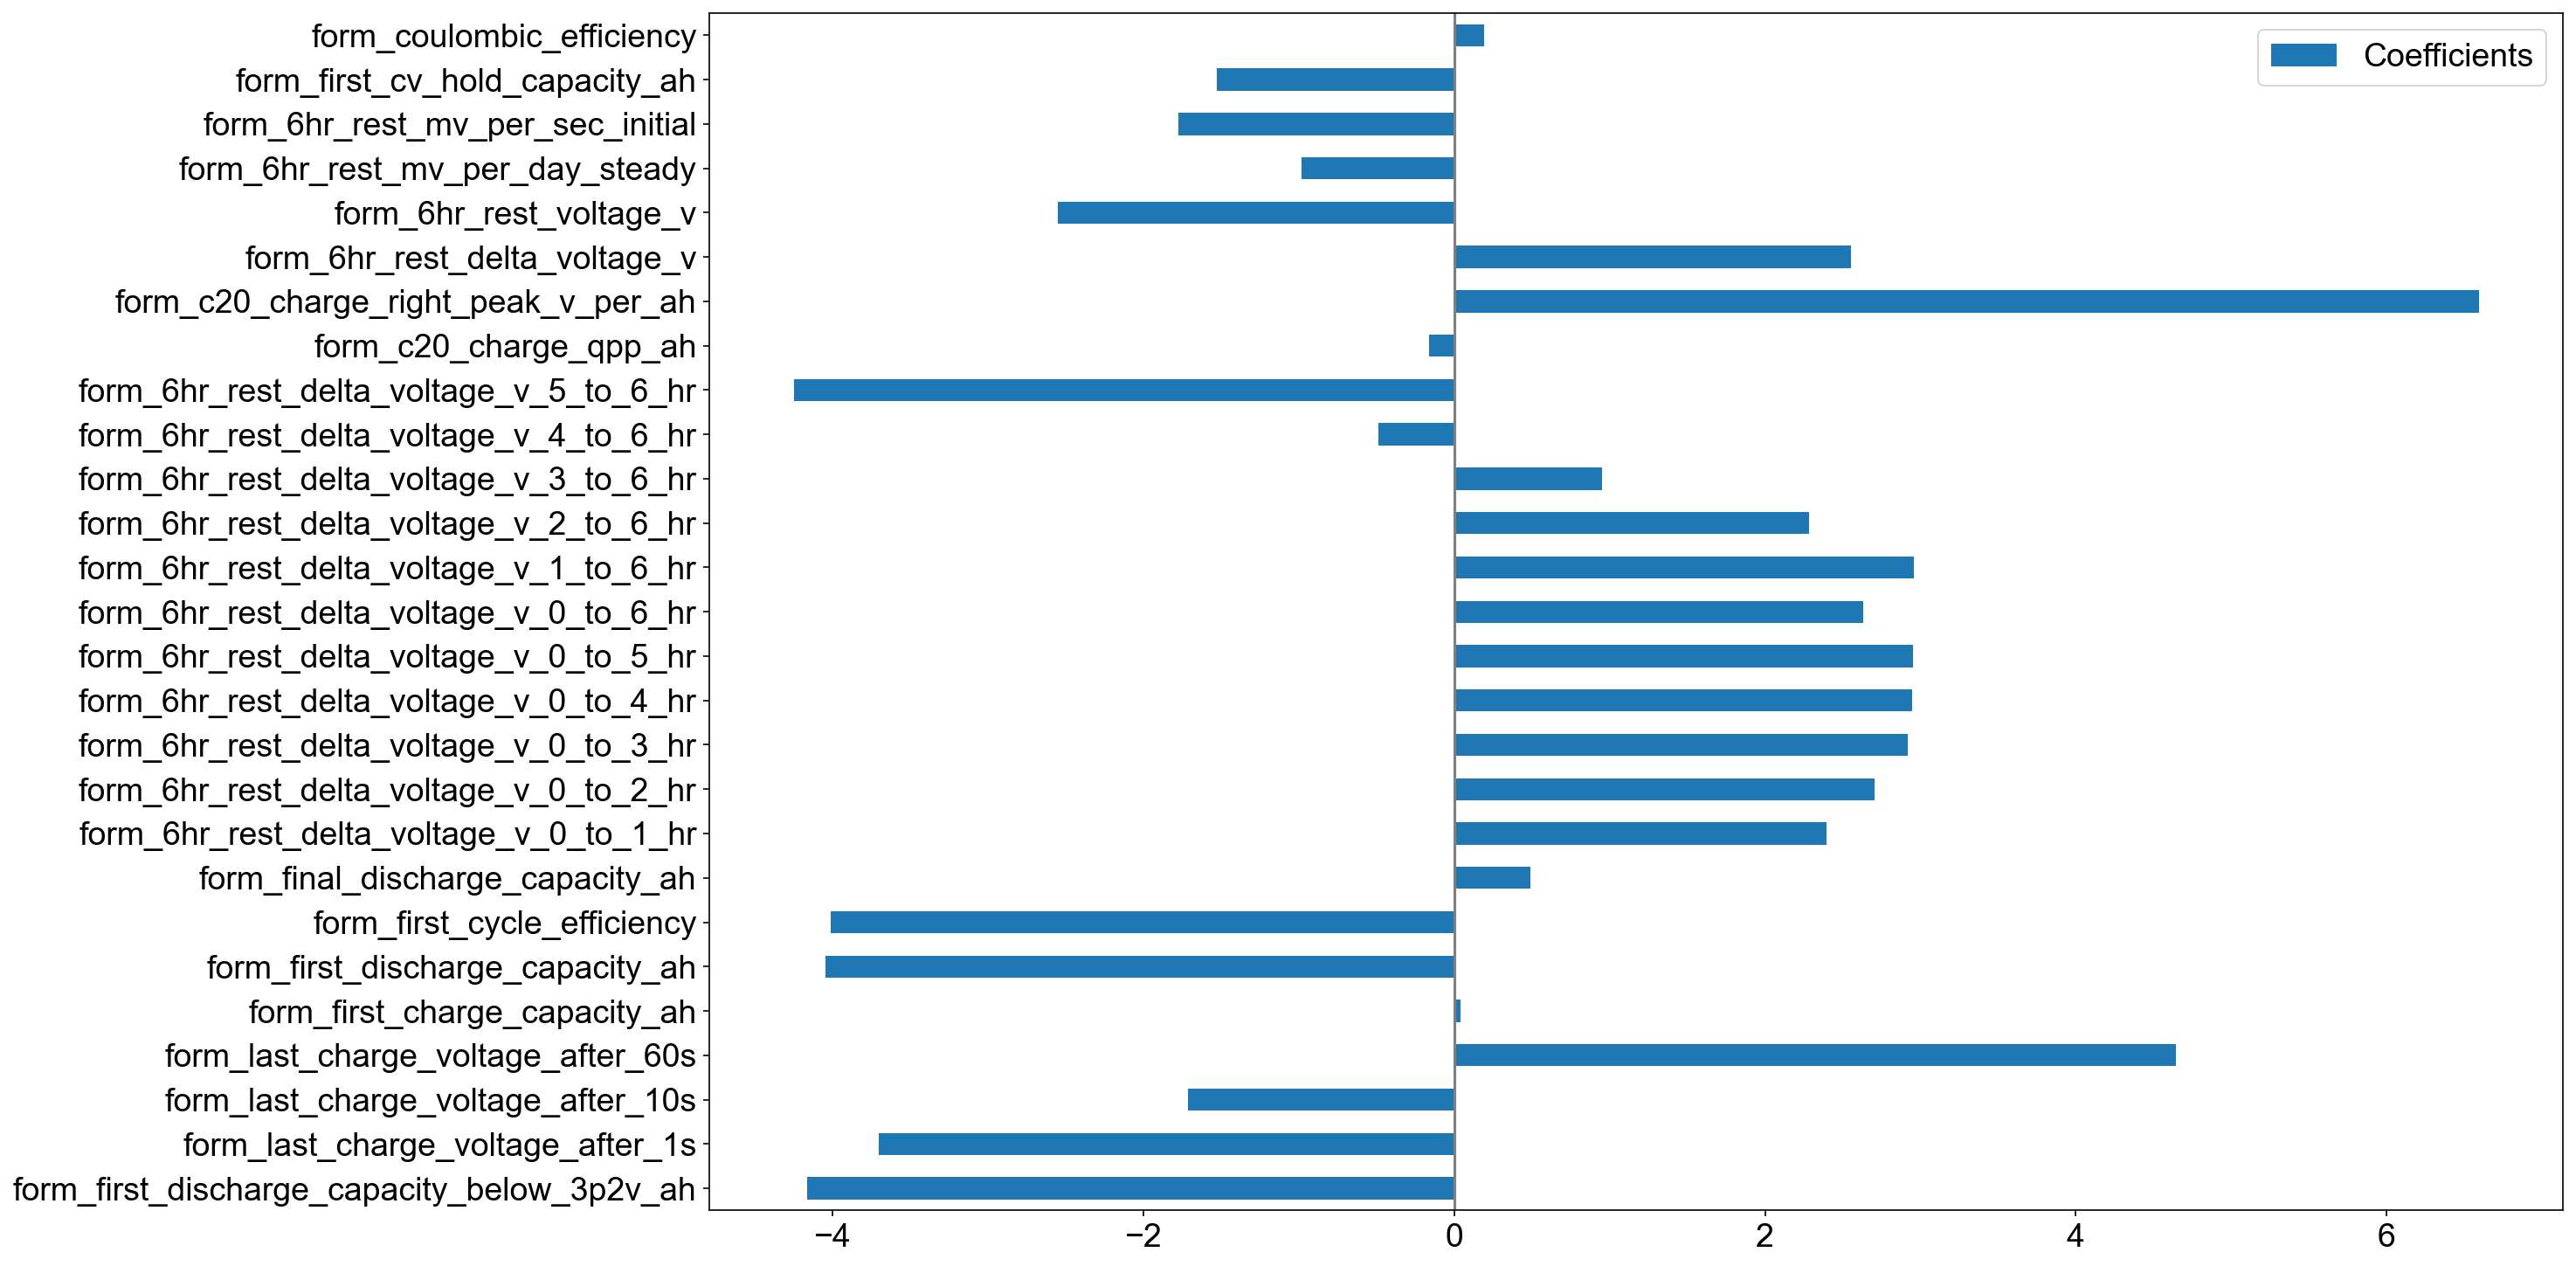

In [49]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(alpha_ridge)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')

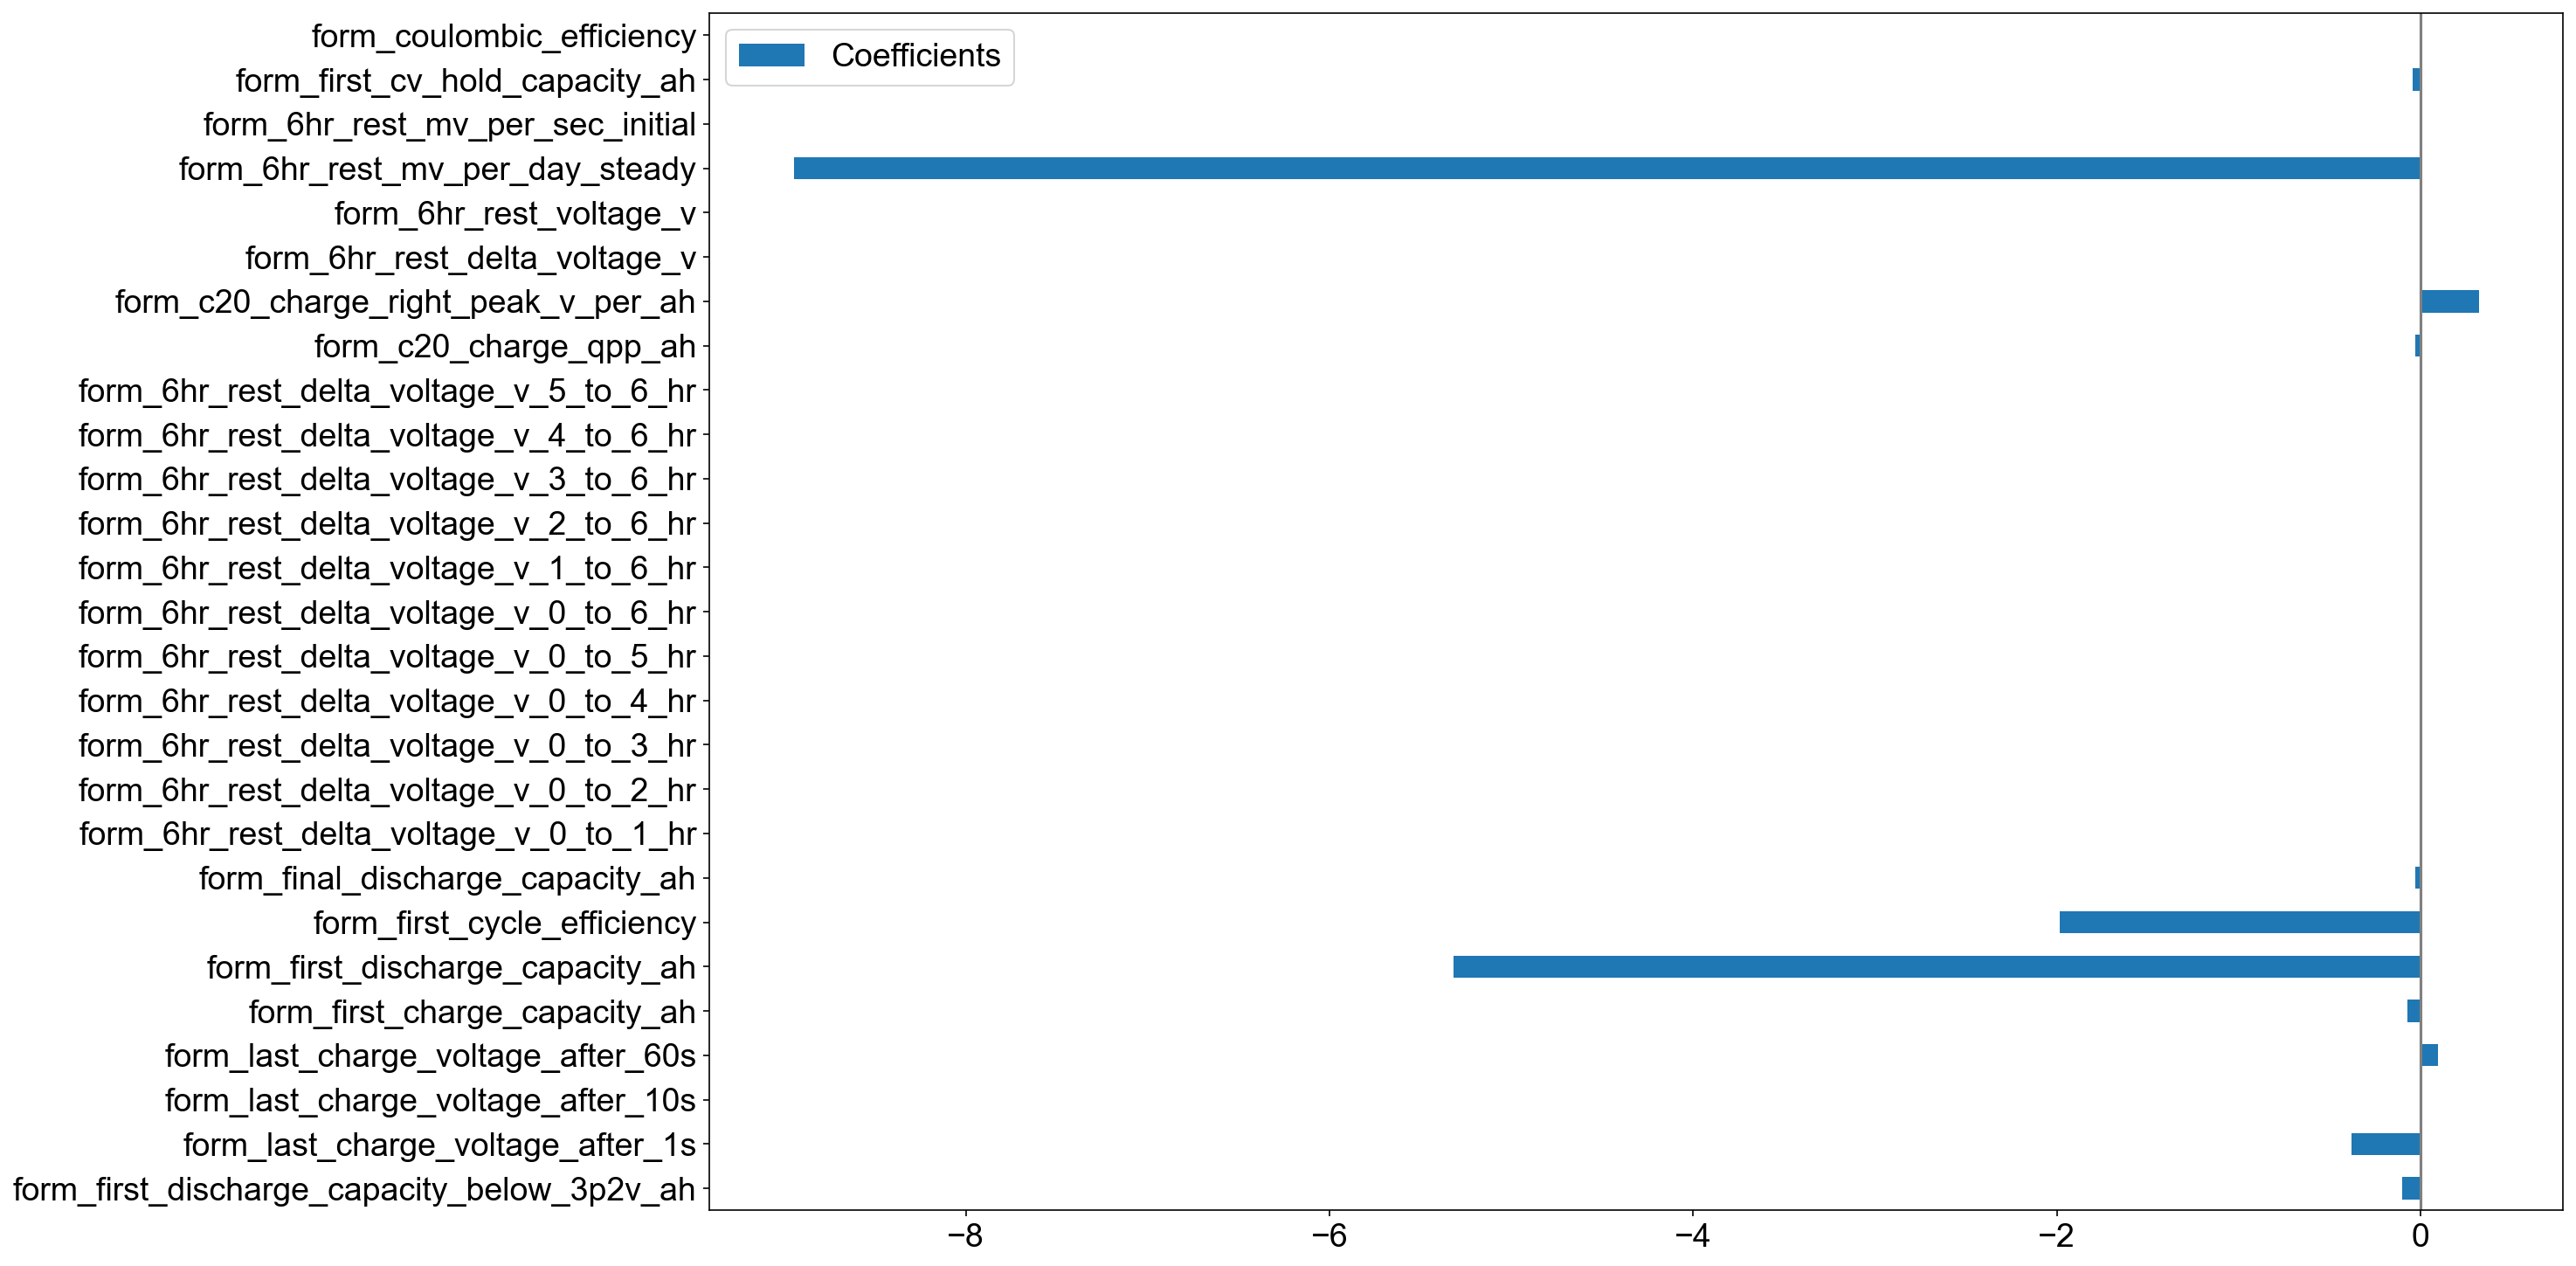

In [50]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(10)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_ * df[form_features].std(axis=0),
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')
plt.savefig(OUTPUT_DIR + "model_coeffs.png")


In [51]:
feat = ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency"]#, "form_6hr_rest_mv_per_day_steady"]
out = train_and_test_model(df, feat, yvar70, to_plot=0, model=Ridge(10), num_experiments=1000, log=True)
print(f"{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

7.89 (2.53 std)


In [52]:
out = train_and_test_model(df, ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency", "form_6hr_rest_mv_per_day_steady"],
                                yvar70, to_plot=0, model=ElasticNet(alpha=0.01,l1_ratio=0.3), num_experiments=1000,
                                  log=True)
print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

form_coulombic_efficiency                         7.79 (2.73 std)


## Polynomial features

In [53]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=True)

# Including features up to cycle 3

In [54]:
c3_select = lambda x: ((x.endswith("_c3") or x.startswith("esoh_c3_") or x.startswith("rpt_c3_"))
                       and not any(s in x for s in ["LLI", "LAM", "Qcomp", "C20_loss"]))
c3_features = list(filter(c3_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_c3 = df[c3_features + labels]
df_c3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retention_at_c3        19 non-null     float64
 1   dcr_10s_0_soc_at_c3    19 non-null     float64
 2   dcr_3s_0_soc_at_c3     19 non-null     float64
 3   dcr_1s_0_soc_at_c3     19 non-null     float64
 4   dcr_10s_5_soc_at_c3    19 non-null     float64
 5   dcr_3s_5_soc_at_c3     19 non-null     float64
 6   dcr_1s_5_soc_at_c3     19 non-null     float64
 7   dcr_10s_7_soc_at_c3    19 non-null     float64
 8   dcr_3s_7_soc_at_c3     19 non-null     float64
 9   dcr_1s_7_soc_at_c3     19 non-null     float64
 10  dcr_10s_10_soc_at_c3   19 non-null     float64
 11  dcr_3s_10_soc_at_c3    19 non-null     float64
 12  dcr_1s_10_soc_at_c3    19 non-null     float64
 13  dcr_10s_15_soc_at_c3   19 non-null     float64
 14  dcr_3s_15_soc_at_c3    19 non-null     float64
 15  dcr_1s_1

In [55]:
df_c3.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct       1.000000
cycles_to_60_pct       0.995579
cycles_to_70_pct       0.976940
cycles_to_80_pct       0.971337
esoh_c3_x100           0.812759
                         ...   
dcr_10s_5_soc_at_c3   -0.792791
esoh_c3_neg_excess    -0.829288
esoh_c3_Cn            -0.831688
esoh_c3_CnCp          -0.845651
esoh_c3_np_ratio      -0.845651
Name: cycles_to_50_pct, Length: 54, dtype: float64

In [56]:
for a in np.logspace(-2,2):
    out = train_and_test_model(df, ["esoh_c3_np_ratio"],#,"form_first_discharge_capacity_ah"], 
                               yvar, to_plot=0, model=Ridge(a), num_experiments=1000, log=True)
    print(f"{a:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

0.01                                              7.97 (1.90 std)
0.012067926406393288                              8.08 (1.87 std)
0.014563484775012436                              7.94 (1.84 std)
0.017575106248547922                              8.02 (1.82 std)
0.021209508879201904                              8.01 (1.85 std)
0.025595479226995357                              8.12 (1.93 std)
0.030888435964774818                              7.94 (1.89 std)
0.0372759372031494                                8.00 (1.80 std)
0.04498432668969444                               8.07 (1.87 std)
0.054286754393238594                              8.05 (1.89 std)
0.0655128556859551                                8.06 (1.90 std)
0.07906043210907697                               7.96 (1.86 std)
0.09540954763499938                               7.92 (1.99 std)
0.1151395399326447                                8.04 (1.88 std)
0.13894954943731375                               7.95 (1.86 std)
0.16768329

PCA

In [57]:
pca = PCA()
pca.fit(df[form_features + c3_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum[:3])
# fig, ax = plt.subplots()
# ax.plot(range(1,len(cumsum)+1),cumsum)
# ax.set_xlabel("Number of PCA components")
# ax.set_ylabel("Explained variance")
# fig.savefig(OUTPUT_DIR + "pca_with_c3.pdf")

[0.84255569 0.99326213 0.99996024]


So now we have two interesting directions

In [58]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = form_features + c3_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

12.317338508587788

# Nested cross-validation

In [59]:
import random

log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
# xvars = form_features +c3_features
xvars = ["form_first_discharge_capacity_ah"]

# Number of trials
num_experiments = 100

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

percent_error_list_outer = []
    
for i in range(num_experiments):    
    df_random = df_nonans.sample(frac=1)

    # save 3 cases for validation
    validate = df_random.iloc[:3]
    train_test = df_random.iloc[3:]
    all_indices = list(range(len(train_test)))

    percent_error_list = []

    best = np.inf

    for alpha in np.linspace(-2,2):
        model = Ridge(alpha)
        for i in range(4):
            test = list(range(i*4,(i+1)*4))
            train = [x for x in all_indices if x not in test]
            Xy_train = train_test.iloc[train]
            Xy_test = train_test.iloc[test]

            X_train = Xy_train[xvars]
            y_train = np.array(Xy_train[yvar])
            X_test = Xy_test[xvars]
            y_test = np.array(Xy_test[yvar])

            # apply standard scaler (fit only on train, transform both train and test)
            # keep originals for pltos
        #     X_train_original = X_train
        #     X_test_original = X_test
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            (model, corr) = build_model(X_train, y_train, model)

            y_pred = model.predict(X_test)
        #     y_train_mean = np.mean(y_train)

        #     r2_score = model.score(X_test, y_test)

        #     if log is True:
        #         y_train = np.exp(y_train)
        #         y_pred = np.exp(y_pred)
        #         y_test = np.exp(y_test)
        #         y_train_mean = np.exp(y_train_mean)

        #     rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
            percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        #     baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

        #     rmse_list.append(rmse)
            percent_error_list.append(percent_error)
        #     r2_score_list.append(r2_score)
        #     baseline_rmse_list.append(baseline_rmse)
            #         intercept_list.append(model.intercept_)
            #         coef_list.append(model.coef_)
        #     corr_list.append(corr)
        score = np.mean(percent_error_list)
        if score < best:
            best = score
            alpha_best = alpha

    # Keep the best model
    model = Ridge(alpha_best)
    X_train = train_test[xvars]
    y_train = np.array(train_test[yvar])
    X_test = validate[xvars]
    y_test = np.array(validate[yvar])
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    (model, corr) = build_model(X_train, y_train, model)
    y_pred = model.predict(X_test)
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    percent_error_list_outer.append(percent_error)
    print(percent_error)

print(np.mean(percent_error_list_outer))

# # Package the output
# final_model = model
# # Column mean and column std of a list of tuples
# #     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
# #     final_model.intercept_ = np.mean(intercept_list)

# final_rmse = np.mean(rmse_list)
# final_rmse_std = np.std(rmse_list)

# final_baseline_rmse = np.mean(baseline_rmse_list)
# final_baseline_rmse_std = np.std(baseline_rmse_list)

# # Column mean and column std of a list of tuples
# final_corr = tuple(map(np.mean, zip(*corr_list)))
# final_corr_std = tuple(map(np.std, zip(*corr_list)))

# final_percent_error = np.mean(percent_error_list)
# final_percent_error_std = np.std(percent_error_list)

# #     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
# final_r2_score = np.mean(r2_score_list)
# final_r2_score_std = np.std(r2_score_list)

# model_output_dict = dict()
# model_output_dict['model'] = final_model
# model_output_dict['rmse'] = final_rmse
# model_output_dict['rmse_std'] = final_rmse_std
# model_output_dict['baseline_rmse'] = final_baseline_rmse
# model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
# model_output_dict['corr'] = final_corr
# model_output_dict['corr_std'] = final_corr_std
# model_output_dict['percent_error'] = final_percent_error
# model_output_dict['percent_error_std'] = final_percent_error_std
# model_output_dict['r2_score'] = final_r2_score
# model_output_dict['r2_score_std'] = final_r2_score_std
# model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
# model_output_dict['features'] = tuple(xvars)

# model_output_dict["percent_error"]

8.808195620488567
3.7543541324749166
3.884712492672652
7.176836616057745
6.359229269093188
8.66056111810303
6.206097809634711
3.331525276824647
9.827134210346731
7.568142848235521
8.28991462221285
3.904631254335552
10.447782376420973
7.318163198405619
15.092910528828865
5.52486144911733
4.749490920827595
7.74245250750716
11.800932429239806
2.8741365326943313
3.262023051380105
3.0199672908472324
7.8075160066045255
9.737765688592864
4.6153566860568045
9.668643291241363
4.921629771185387
6.61577450136279
8.742209740375085
6.5989511749557455
2.3174129715850786
11.858124190631502
4.939005481103431
8.847300386284529
2.783363893817395
4.427426171544011
10.915078332047278
4.303265658483961
9.369365242285621
5.012415287543517
5.647279725990492
5.772906479666907
6.328743546946875
7.678577139418223
7.062285924221036
8.161335965838425
7.2534936828969565
3.777315413365432
5.834013505340723
5.694551479837821
5.617334545912318
4.6183524734909644
6.625299431340769
9.792055190891274
6.951416311342127
3

In [60]:
y_train

array([363, 362, 378, 437, 514, 381, 405, 441, 362, 338, 455, 461, 479,
       520, 590, 373])

In [61]:
df.iloc[:4]

Unnamed: 0  cellid  channel_number  is_room_temp_aging  \
0           0       1              22                   0   
1           1       2              23                   0   
2           2       3              24                   0   
3           3       4              25                   0   

   is_baseline_formation  form_first_discharge_capacity_below_3p2v_ah  \
0                      1                                     0.077820   
1                      1                                     0.073791   
2                      1                                     0.074725   
3                      1                                     0.069433   

   form_first_discharge_rest_voltage_rebound_1s  \
0                                      3.010586   
1                                      3.011151   
2                                      3.010842   
3                                      3.010670   

   form_first_discharge_rest_voltage_rebound_10s  \
0                                       3.057576   
1                                       3.061895   
2                                       3.060853   
3                                       3.059812   

   form_first_discharge_rest_voltage_rebound_1800s  \
0                                         3.382315   
1                                         3.388266   
2                                         3.386511   
3                                         3.386282   

               form_last_charge_voltage_trace_cap_ah  \
0  1559    2.185772\n1560    2.195145\n1561    2....   
1  1554    2.179028\n1555    2.188387\n1556    2....   
2  1566    2.179772\n1567    2.189165\n1568    2....   
3  1557    2.158946\n1558    2.168266\n1559    2....   

            form_last_charge_voltage_trace_voltage_v  \
0  1559    4.102388\n1560    4.107424\n1561    4....   
1  1554    4.102846\n1555    4.107958\n1556    4....   
2  1566    4.104143\n1567    4.109178\n1568    4....   
3  1557    4.100328\n1558    4.105364\n1559    4....   

   form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                           3.393505                            3.403936   
1                           3.401924                            3.412256   
2                           3.398755                            3.409052   
3                           3.400189                            3.410498   

   form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                            3.420587                       2.755302   
1                            3.428007                       2.698299   
2                            3.424840                       2.713403   
3                            3.426320                       2.696613   

   form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
0                          2.312734                     0.839376   
1                          2.313851                     0.857522   
2                          2.309945                     0.851309   
3                          2.310417                     0.856785   

   form_final_discharge_capacity_ah  form_6hr_rest_delta_voltage_v_0_to_1_hr  \
0                          2.367225                                 0.011104   
1                          2.363418                                 0.010694   
2                          2.362668                                 0.011531   
3                          2.356018                                 0.010730   

   form_6hr_rest_delta_voltage_v_0_to_2_hr  \
0                                 0.014412   
1                                 0.013741   
2                                 0.015044   
3                                 0.013928   

   form_6hr_rest_delta_voltage_v_0_to_3_hr  \
0                                 0.016395   
1                                 0.015612   
2                                 0.017074   
3                                 0.015780   

   form_6hr_rest_delta_voltage_v_0_

# Next steps
- Nested cross-val
- Quadratic error
- Cycle 3

In [69]:
for i in range(10):
    print(df.columns[i*100:i*100+100])

Index(['Unnamed: 0', 'cellid', 'channel_number', 'is_room_temp_aging',
       'is_baseline_formation', 'form_first_discharge_capacity_below_3p2v_ah',
       'form_first_discharge_rest_voltage_rebound_1s',
       'form_first_discharge_rest_voltage_rebound_10s',
       'form_first_discharge_rest_voltage_rebound_1800s',
       'form_last_charge_voltage_trace_cap_ah',
       'form_last_charge_voltage_trace_voltage_v',
       'form_last_charge_voltage_after_1s',
       'form_last_charge_voltage_after_10s',
       'form_last_charge_voltage_after_60s', 'form_first_charge_capacity_ah',
       'form_first_discharge_capacity_ah', 'form_first_cycle_efficiency',
       'form_final_discharge_capacity_ah',
       'form_6hr_rest_delta_voltage_v_0_to_1_hr',
       'form_6hr_rest_delta_voltage_v_0_to_2_hr',
       'form_6hr_rest_delta_voltage_v_0_to_3_hr',
       'form_6hr_rest_delta_voltage_v_0_to_4_hr',
       'form_6hr_rest_delta_voltage_v_0_to_5_hr',
       'form_6hr_rest_delta_voltage_v_0_to_6_hr'